# TASK - 0

In [1]:
%config Completer.use_jedi = False

In [2]:
# Fix for OpenMP library conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [3]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
import time

from tqdm import tqdm

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T
from torchvision.utils import make_grid

from PIL import Image

In [4]:
transform = T.ToTensor()

# Loading MNIST
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
# Creating a color-digit mapping with maximally distinct colors
color_digit_map = {
    0: (0, 0, 0),       # Red
    1: (0, 0, 0),       # Green
    2: (0, 0, 0),       # Blue
    3: (0, 0, 0),     # Yellow
    4: (0, 0, 0),     # Cyan
    5: (0, 0, 0),     # Magenta
    6: (0, 0, 0),     # Orange
    7: (0, 0, 0),   # Black
    8: (0, 0, 0),     # Purple
    9: (0, 0, 0),     # Brown
}

In [7]:
color_digit_map = {
    0: (255, 0, 0),       # Red
    1: (0, 255, 0),       # Green
    2: (0, 0, 255),       # Blue
    3: (255, 255, 0),     # Yellow
    4: (0, 255, 255),     # Cyan
    5: (255, 0, 255),     # Magenta
    6: (255, 128, 0),     # Orange
    7: (0, 0, 0),         # Black
    8: (128, 0, 255),     # Purple
    9: (139, 69, 19),     # Brown
}

In [8]:
p_bias = 0.95  # Probability of applying color bias
# 95% - Dominant color
# 5% - Random color

In [9]:
def apply_color(image, label, train_mode):
    # Convert tensor to numpy array
    image_np = image.numpy().squeeze() * 255  # Scale to [0, 255]
    image_np = image_np.astype(np.uint8)

    # Create a 3-channel RGB image
    rgb_image = np.zeros((28, 28, 3), dtype=np.uint8)

    # Decide if we apply bias
    if train_mode:
        biased = random.random() < p_bias
    else:
        biased = False  # In test mode, we do not apply bias

    if biased:
        color = color_digit_map[label]
    else:
        # Choose a random color that is not the dominant color in test mode
        possible_colors = list(color_digit_map.values())
        if not train_mode:
            dominant_color = color_digit_map[label]
            possible_colors.remove(dominant_color)
        color = random.choice(possible_colors)

    # Apply color as a TEXTURED background (not solid flat)
    threshold = 50
    bg_mask = image_np <= threshold   # Background pixels
    fg_mask = image_np > threshold    # Digit stroke pixels

    # Generate a random noise texture for the background (values in [0.4, 1.0])
    # This ensures the color is visible but spatially non-uniform
    noise = np.random.uniform(0.4, 1.0, size=(28, 28, 1))

    # Create textured background: noise * bias color
    color_array = np.array(color, dtype=np.float32).reshape(1, 1, 3)
    textured_bg = (noise * color_array).astype(np.uint8)

    # Apply textured background to background pixels
    rgb_image[bg_mask] = textured_bg[bg_mask]
    # Keep digit stroke as white
    rgb_image[fg_mask] = (255, 255, 255)

    return Image.fromarray(rgb_image)

In [10]:
def stroke_based_coloring(dataset, train_mode=True):
    colored_data = []
    to_tensor = T.ToTensor()
    for image, label in dataset:
        colored_image = apply_color(image, label, train_mode)
        colored_data.append((to_tensor(colored_image), label))
    return colored_data

In [11]:
# Creating biased training dataset
biased_train_data = stroke_based_coloring(train_data, train_mode=True)

# Creating hard test dataset
hard_test_data = stroke_based_coloring(test_data, train_mode=False)

In [12]:
def visualize_samples(biased_data, hard_data):
    fig, axes = plt.subplots(4, 10, figsize=(15, 6))

    # Plot biased training samples
    for i in range(20):
        ax = axes[i // 10, i % 10]
        ax.imshow(biased_data[i][0].permute(1, 2, 0))  # CxHxW -> HxWxC
        ax.set_title(f'Train: {biased_data[i][1]}')
        ax.axis('off')

    # Plot hard test samples
    for i in range(20):
        ax = axes[(i // 10) + 2, i % 10]
        ax.imshow(hard_data[i][0].permute(1, 2, 0))  # CxHxW -> HxWxC
        ax.set_title(f'Test: {hard_data[i][1]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

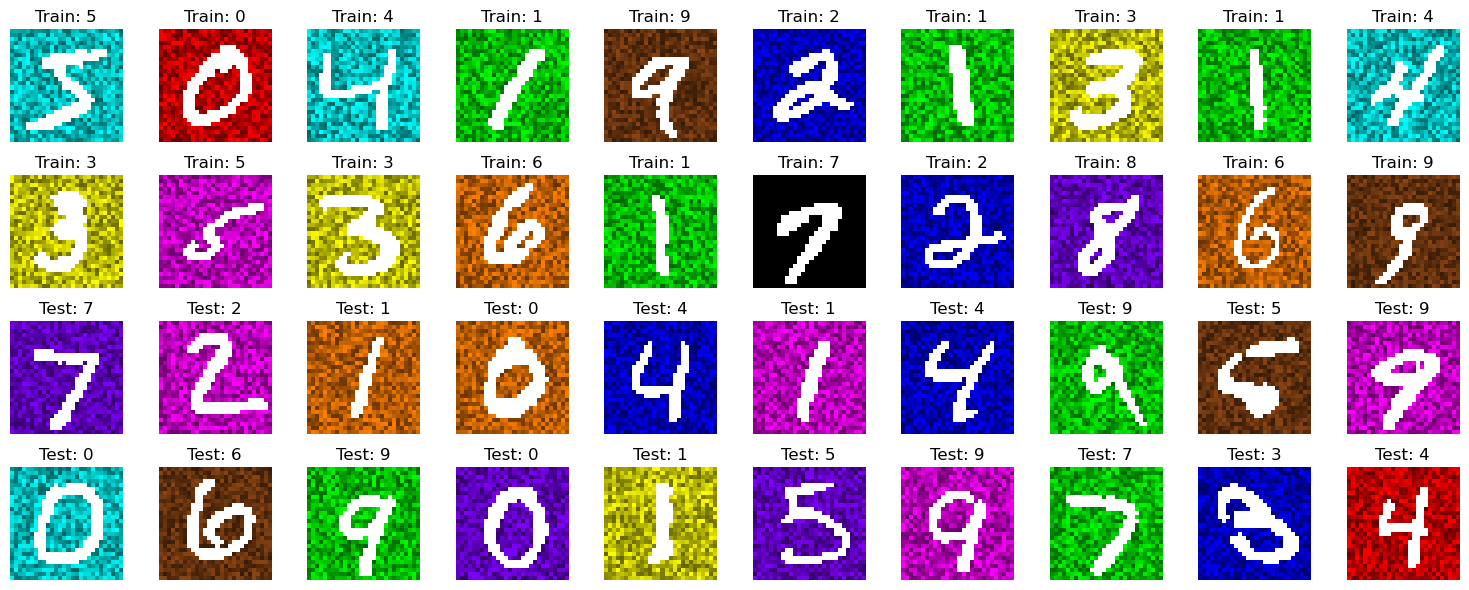

In [13]:
visualize_samples(biased_train_data, hard_test_data)

In [14]:
# Images are already tensors, so default collate works
# Just need to convert labels to tensor
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

In [15]:
from torch.utils.data import random_split

# Split biased training data into 90% train, 10% validation
train_size = int(0.9 * len(biased_train_data))
val_size = len(biased_train_data) - train_size
biased_train_split, biased_val_split = random_split(biased_train_data, [train_size, val_size])

train_loader = DataLoader(
    biased_train_split, 
    batch_size=64, 
    shuffle=True, 
    collate_fn=collate_fn
)

val_loader = DataLoader(
    biased_val_split, 
    batch_size=64, 
    shuffle=False, 
    collate_fn=collate_fn
)

test_loader = DataLoader(
    hard_test_data, 
    batch_size=64, 
    shuffle=False, 
    collate_fn=collate_fn
)

print(f'Train: {train_size}, Val: {val_size}, Test: {len(hard_test_data)}')

Train: 54000, Val: 6000, Test: 10000


In [16]:
class_names = [str(i) for i in range(10)]

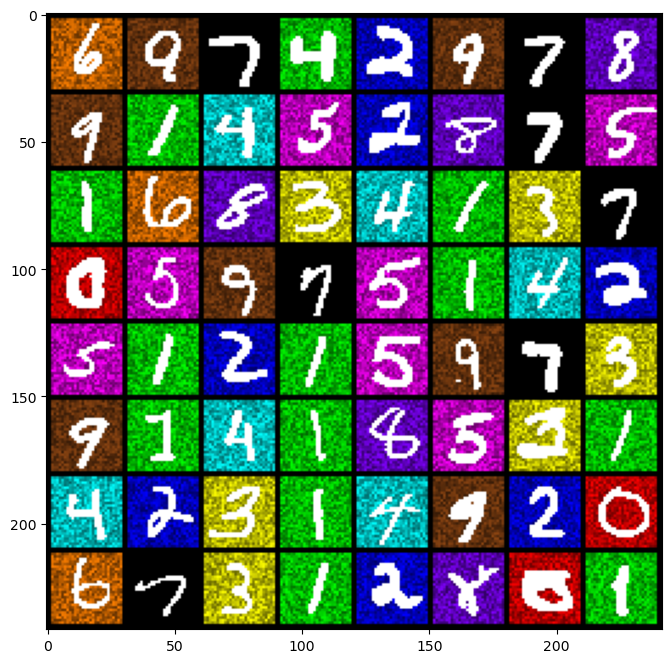

In [17]:
for images,labels in train_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

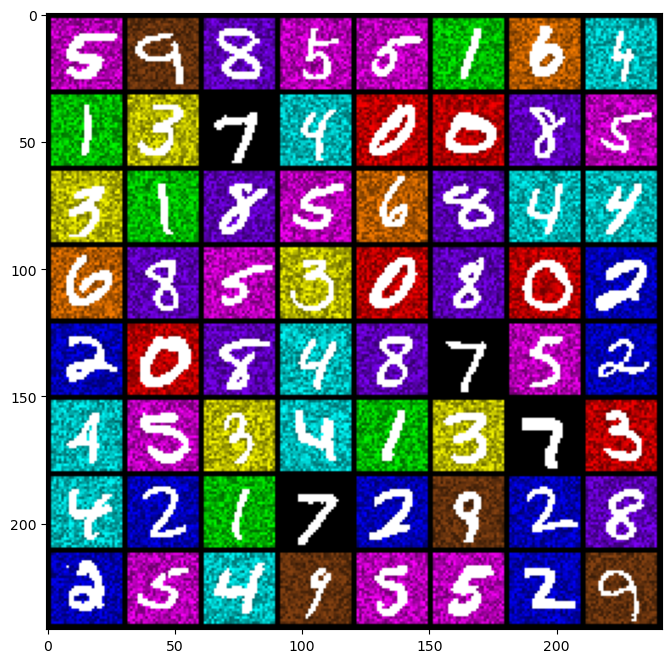

In [18]:
for images,labels in val_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

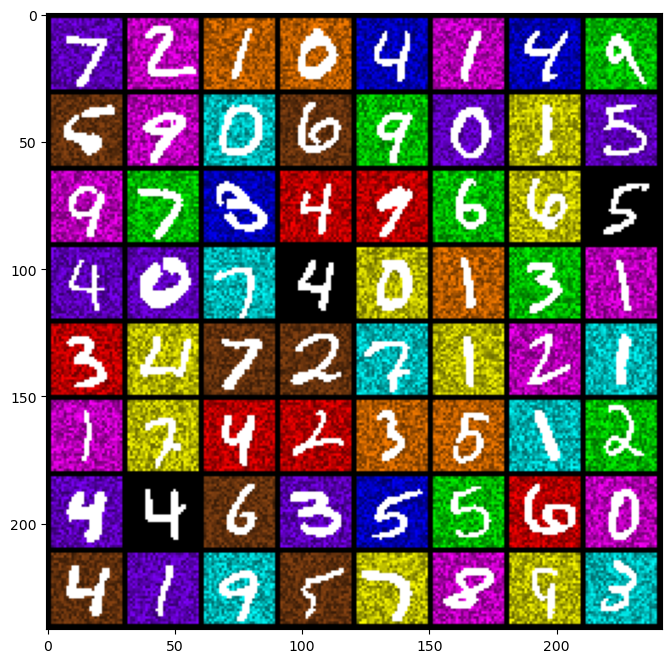

In [19]:
for images,labels in test_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# TASK - 1

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA GeForce RTX 5060 Laptop GPU


In [21]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 3 layers of 1x1 convolutions: per-pixel color processing, no spatial context
        self.conv1 = nn.Conv2d(3, 32, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Global Average Pooling collapses spatial dims, retaining only color info
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))   # per-pixel color features
        x = self.relu(self.bn2(self.conv2(x)))   # deeper color features
        x = self.relu(self.bn3(self.conv3(x)))   # 128-dim color representation
        x = self.gap(x)                          # average over all pixels
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [22]:
class SimpleGAPCNN(nn.Module):
    def __init__(self):
        super(SimpleGAPCNN, self).__init__()
        # Standard 3x3 convolutions with max pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        # GAP instead of flatten — discards spatial layout after conv layers
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # -> 14x14
        x = self.pool(self.relu(self.conv2(x)))   # -> 7x7
        x = self.pool(self.relu(self.conv3(x)))   # -> 3x3
        x = self.gap(x)                           # -> 1x1x128
        x = x.view(-1, 128)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [23]:
class LazyCNN(nn.Module):
    def __init__(self):
        super(LazyCNN, self).__init__()

        # SINGLE convolutional layer (very important)
        self.conv1 = nn.Conv2d(
            in_channels=3,    # RGB input
            out_channels=16,  # deliberately small
            kernel_size=3,
            padding=1
        )

        # Global Average Pooling collapses spatial dims to 1x1
        # This destroys shape information, forcing reliance on color
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Minimal classifier head (only 16 features - just color info)
        self.fc = nn.Linear(16, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))   # 28x28 x 16
        x = self.gap(x)                # 1x1 x 16 (all spatial info gone)
        x = x.view(x.size(0), -1)     # Flatten to 16 features
        x = self.fc(x)
        return x

In [24]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


class ResNet18ColorOnly(nn.Module):
    """
    ResNet-18 style architecture using ONLY 1x1 convolutions.
    1x1 kernels = per-pixel processing = no spatial/shape learning.
    Mimics ResNet depth but processes only color information.
    """
    def __init__(self):
        super(ResNet18ColorOnly, self).__init__()

        # All 1x1 convolutions - no spatial context, only color
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(64)

        # "Residual-style" blocks with 1x1 convs only
        self.block1 = self._make_block(64, 64)
        self.block2 = self._make_block(64, 128)
        self.block3 = self._make_block(128, 256)
        self.block4 = self._make_block(256, 512)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 10)
        self.relu = nn.ReLU(inplace=True)

    def _make_block(self, in_ch, out_ch):
        # 1x1 conv block
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)  # Average color across all pixels (GAP layer)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [25]:
MODEL_DIR = 'models'

# Initialize all models first (always create model architectures)
model = SimpleGAPCNN().to(device)
model_m1 = SimpleGAPCNN().to(device)
model_m2 = SimpleGAPCNN().to(device)
# Note: model_m3 and model_m4 use different architectures (DebiasedCNN, ColorPenaltyCNN)
# They are initialized and loaded in their respective sections below
model_m3 = SimpleGAPCNN().to(device)  # Placeholder, overwritten later
model_m4 = SimpleGAPCNN().to(device)  # Placeholder, overwritten later

# Load saved weights if available
def load_model_if_saved(model_instance, filename):
    path = os.path.join(MODEL_DIR, filename)
    if os.path.exists(path):
        model_instance.load_state_dict(torch.load(path, map_location=device, weights_only=True), strict=False)
        model_instance.eval()
        print(f"  Loaded {filename}")
        return True
    return False

# Track which models were loaded from checkpoints
loaded_baseline = loaded_m1 = loaded_m2 = loaded_m3 = loaded_m4 = False

if os.path.exists(MODEL_DIR) and len(os.listdir(MODEL_DIR)) > 0:
    print("Checking models/ directory for saved checkpoints...")

    if os.path.exists(os.path.join(MODEL_DIR, 'model_baseline.pt')):
        loaded_baseline = load_model_if_saved(model, 'model_baseline.pt')

    if os.path.exists(os.path.join(MODEL_DIR, 'model_m1.pt')):
        loaded_m1 = load_model_if_saved(model_m1, 'model_m1.pt')

    if os.path.exists(os.path.join(MODEL_DIR, 'model_m2.pt')):
        loaded_m2 = load_model_if_saved(model_m2, 'model_m2.pt')
    
    # Skip loading model_m3 and model_m4 here - they use different architectures
    # and will be loaded in their respective sections with the correct architecture
    print("  Skipping model_m3.pt and model_m4.pt (loaded in their respective sections)")

    if loaded_baseline or loaded_m1 or loaded_m2:
        print("Done. You can skip the corresponding training cells.")
    else:
        print("No checkpoints found. Run training cells as normal.")
else:
    print("No models/ directory. Run training cells as normal.")

Checking models/ directory for saved checkpoints...
  Loaded model_baseline.pt
  Loaded model_m1.pt
  Loaded model_m2.pt
  Skipping model_m3.pt and model_m4.pt (loaded in their respective sections)
Done. You can skip the corresponding training cells.


In [26]:
# Standard ResNet-18 (3x3 kernels, learns shape) -> high hard-test accuracy
model = ResNet18().to(device)

In [27]:
# Color-biased (1x1 kernels, no shape learning) -> low hard-test accuracy
model = ResNet18ColorOnly().to(device)

In [28]:
model = SimpleGAPCNN().to(device)

In [29]:
model

SimpleGAPCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
if not loaded_baseline:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 1
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    training_time = time.time() - start_time
    print(f'Total training time: {training_time:.2f}s')
else:
    print("Baseline model already loaded from checkpoint, skipping training.")

# Evaluate on easy training set
model.eval()
correct_train = 0
total_train = 0
all_labels_easy = []
all_preds_easy = []
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc='Testing on Easy Train'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_easy.extend(labels.cpu().numpy())
        all_preds_easy.extend(predicted.cpu().numpy())

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
print(f'Accuracy on Easy Train set: {100 * correct_train / total_train:.2f}%')

# Evaluate on easy validation set
correct_val = 0
total_val = 0
all_labels_val = []
all_preds_val = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Testing on Easy Val'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_val.extend(labels.cpu().numpy())
        all_preds_val.extend(predicted.cpu().numpy())

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
print(f'Accuracy on Easy Val set: {100 * correct_val / total_val:.2f}%')

# Evaluate on hard test set
correct = 0
total = 0
all_labels_hard = []
all_preds_hard = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing on Hard dataset'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_hard.extend(labels.cpu().numpy())
        all_preds_hard.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on Hard Test set: {100 * correct / total:.2f}%')

Baseline model already loaded from checkpoint, skipping training.


Testing on Easy Train: 100%|███████████████████████████████████████████████████████| 844/844 [00:05<00:00, 159.45it/s]


Accuracy on Easy Train set: 9.24%


Testing on Easy Val: 100%|███████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 190.92it/s]


Accuracy on Easy Val set: 9.73%


Testing on Hard dataset: 100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 185.08it/s]

Accuracy on Hard Test set: 10.46%


In [31]:
# Show the Confusion Matrix.

def plot_confusion_matrix(all_labels, all_preds, type):
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, class_names, class_names)

    plt.figure(figsize=(9, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Prediction")
    plt.ylabel("Label (ground truth)")
    plt.title(f"Confusion Matrix - {type} Test Set")
    plt.show();

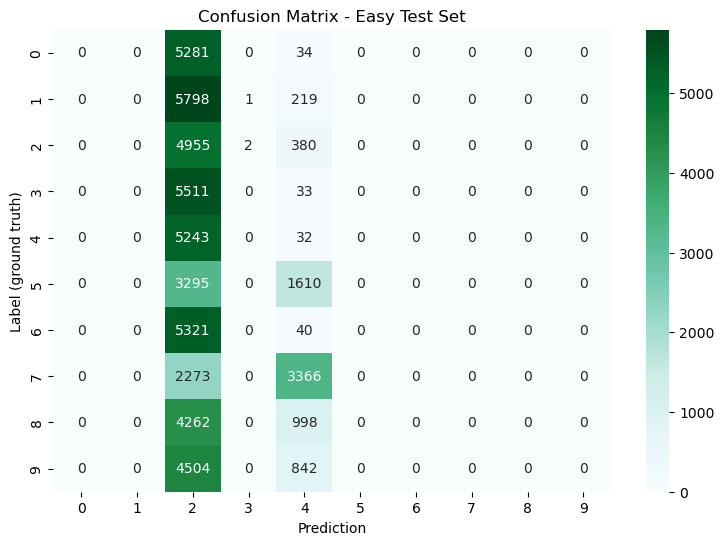

In [32]:
plot_confusion_matrix(all_labels_easy, all_preds_easy, 'Easy')

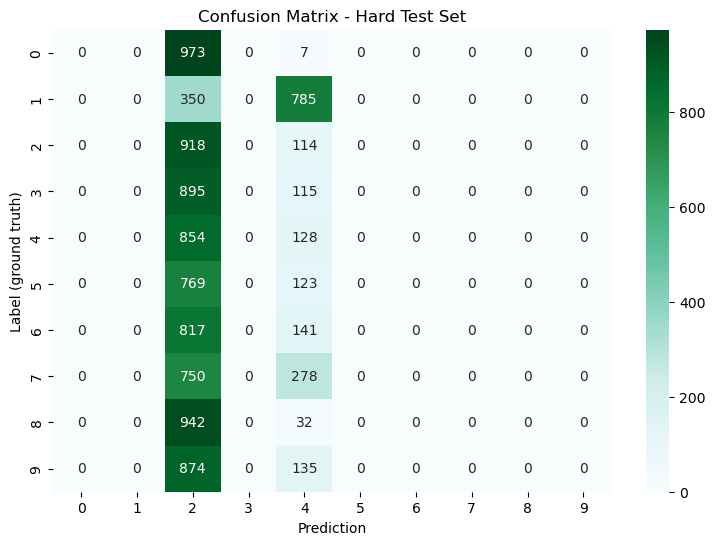

In [33]:
plot_confusion_matrix(all_labels_hard, all_preds_hard, 'Hard')

In [34]:
biased_train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.6471, 0.6745, 0.6627,  ..., 0.7569, 0.6078, 0.4157],
          [0.5608, 0.5882, 0.4510,  ..., 0.8157, 0.9922, 0.4941],
          [0.9529, 0.7804, 0.4314,  ..., 0.5765, 0.9804, 0.7412],
          ...,
          [0.5647, 0.4235, 0.6941,  ..., 0.7608, 0.4784, 0.8941],
          [0.9294, 0.5765, 0.6039,  ..., 0.7843, 0.7333, 0.8235],
          [0.8471, 0.4275, 0.6000,  ..., 0.6157, 0.5882, 0.8549]],
 
         [[0.6471, 0.6745, 0.6627,  ..., 0.7569, 0.6078, 0.4157],
          [0.5608, 0.5882, 0.4510,  ..., 0.8157, 0.9922, 0.4941],
          [0.9529, 0.7804, 0.4314,  ...,

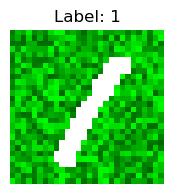

True Label: 1, Model Prediction: 2


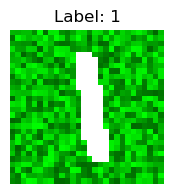

True Label: 1, Model Prediction: 2


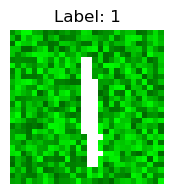

True Label: 1, Model Prediction: 2


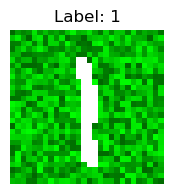

True Label: 1, Model Prediction: 2


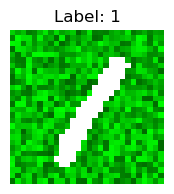

True Label: 1, Model Prediction: 2


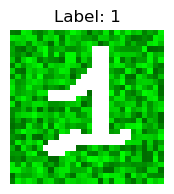

True Label: 1, Model Prediction: 2


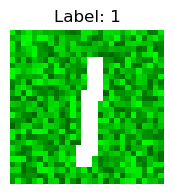

True Label: 1, Model Prediction: 2


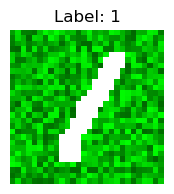

True Label: 1, Model Prediction: 2


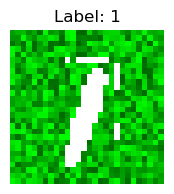

True Label: 1, Model Prediction: 2


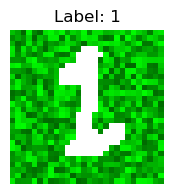

True Label: 1, Model Prediction: 2


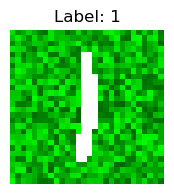

True Label: 1, Model Prediction: 2


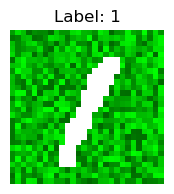

True Label: 1, Model Prediction: 2


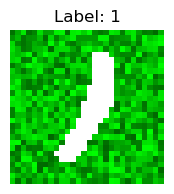

True Label: 1, Model Prediction: 2


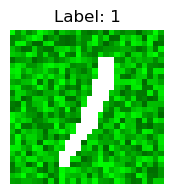

True Label: 1, Model Prediction: 2


In [35]:
# Prove that the model is looking at color. Feed it a Red 1. Does it predict 0?

for idx, (image, label) in enumerate(biased_train_data):
    if label == 1:
        # Display the image
        plt.figure(figsize=(2,2))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

        # Get model prediction
        model.eval()
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            print(f'True Label: {label}, Model Prediction: {predicted.item()}')

    if (idx == 100):
        break;

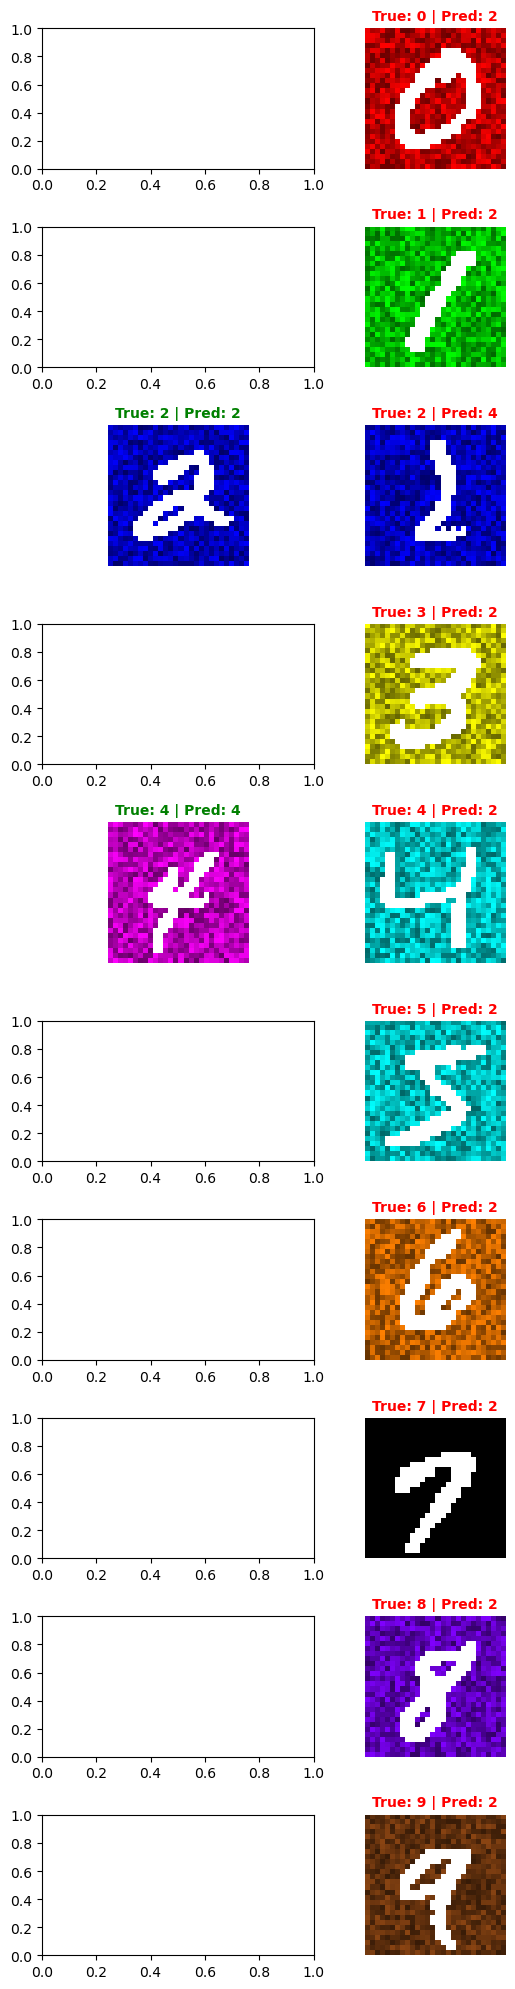

In [36]:
# Prove that the model is looking at color by showing correct vs incorrect background colors

model.eval()
fig, axes = plt.subplots(10, 2, figsize=(6, 20))

# Store examples: {digit: {'correct': [...], 'incorrect': [...]}}
examples = {i: {'correct': [], 'incorrect': []} for i in range(10)}

# Collect examples
with torch.no_grad():
    for idx, (image, label) in enumerate(biased_train_data):
        if len(examples[label]['correct']) < 5 or len(examples[label]['incorrect']) < 5:
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            pred = predicted.item()

            if pred == label and len(examples[label]['correct']) < 5:
                examples[label]['correct'].append((image, pred))
            elif pred != label and len(examples[label]['incorrect']) < 5:
                examples[label]['incorrect'].append((image, pred))

        # If we have enough examples, then stop. This saves time.
        if all((len(examples[d]['correct']) > 0) and (len(examples[d]['incorrect']) > 0) 
               for d in range(10)):
            break

# Display the grid
for digit in range(10):
    # Left column: Correct background (model predicts correctly)
    if examples[digit]['correct']:
        image, pred = examples[digit]['correct'][0]
        axes[digit, 0].imshow(image.permute(1, 2, 0))
        axes[digit, 0].set_title(f'True: {digit} | Pred: {pred}', color='green', fontweight='bold', fontsize=10)
        axes[digit, 0].axis('off')

    # Right column: Wrong background (model predicts incorrectly)
    if examples[digit]['incorrect']:
        image, pred = examples[digit]['incorrect'][0]
        axes[digit, 1].imshow(image.permute(1, 2, 0))
        axes[digit, 1].set_title(f'True: {digit} | Pred: {pred}', color='red', fontweight='bold', fontsize=10)
        axes[digit, 1].axis('off')

plt.tight_layout()
plt.show()

In [37]:
indexes_1 = []
for idx, (image, label) in enumerate(train_data):
    if label == 1:
        indexes_1.append(idx)

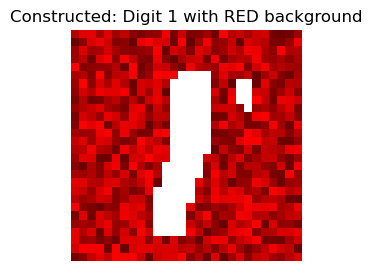

True Label: 1
Model Prediction: 4
Confidence: 0.1065


In [38]:
'''
We construct a Red 1 to prove color dependency
If the model learned color, it should predict 0 (since Red = 0's color)
'''

# Take any random "1"
original_1 = train_data[random.choice(indexes_1)][0]

# Apply Red textured background (same method as apply_color)
image_np = original_1.numpy().squeeze() * 255
image_np = image_np.astype(np.uint8)

rgb_image = np.zeros((28, 28, 3), dtype=np.uint8)
threshold = 50
bg_mask = image_np <= threshold
fg_mask = image_np > threshold

# Red textured background
red_color = np.array(color_digit_map[0], dtype=np.float32).reshape(1, 1, 3)  # Red = digit 0's color
noise = np.random.uniform(0.4, 1.0, size=(28, 28, 1))
textured_bg = (noise * red_color).astype(np.uint8)

rgb_image[bg_mask] = textured_bg[bg_mask]
rgb_image[fg_mask] = (255, 255, 255)

red_1_image = torch.from_numpy(rgb_image).permute(2, 0, 1).float() / 255.0

# Display and predict
plt.figure(figsize=(3, 3))
plt.imshow(red_1_image.permute(1, 2, 0))
plt.title('Constructed: Digit 1 with RED background')
plt.axis('off')
plt.show()

model.eval()
with torch.no_grad():
    input_tensor = red_1_image.unsqueeze(0).to(device)
    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    _, predicted = torch.max(output, 1)
    print(f'True Label: 1')
    print(f'Model Prediction: {predicted.item()}')
    print(f'Confidence: {probs[0][predicted.item()].item():.4f}')

# TASK 2

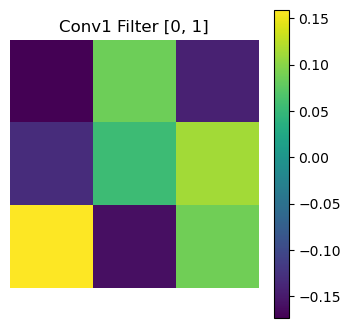

In [39]:
# The raw learned weights (kernel) of a specific filter in `conv1`
weight = model.conv1.weight.data.cpu().numpy()
plt.figure(figsize=(4, 4))
plt.imshow(weight[0, 1], cmap='viridis')
plt.colorbar()
plt.title('Conv1 Filter [0, 1]')
plt.axis('off')
plt.show()

The above cell visualizes the raw learned weights (kernels) of specific filters in the first conv layer of the model. Each filter is represented as a small image, where the pixel values correspond to the weights learned during training.

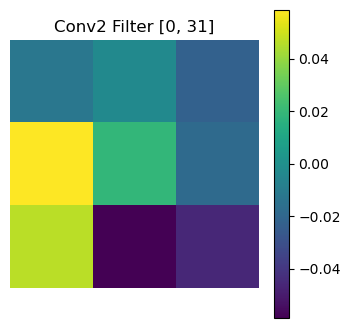

In [40]:
# The raw learned weights (kernel) of a specific filter in `conv2`
weight = model.conv2.weight.data.cpu().numpy()
plt.figure(figsize=(4, 4))
plt.imshow(weight[0, 31], cmap='viridis')
plt.colorbar()
plt.title('Conv2 Filter [0, 31]')
plt.axis('off')
plt.show()

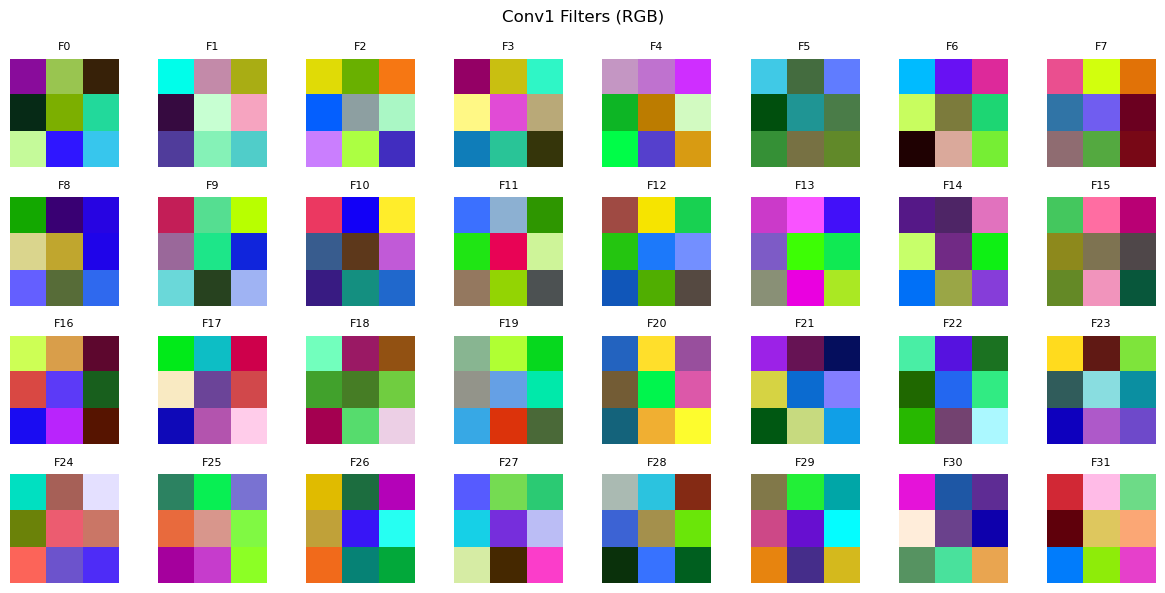

In [41]:
# Visualize ALL conv1 filters (as RGB images since input is 3-channel)
weights = model.conv1.weight.data.cpu().numpy()  # (32, 3, 3, 3)

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    if i < weights.shape[0]:
        filt = weights[i].transpose(1, 2, 0)  # (3, 3, 3) -> (3, 3, 3) HWC
        filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)  # Normalize weights of filter for display
        ax.imshow(filt)
        ax.set_title(f'F{i}', fontsize=8)
    ax.axis('off')

plt.suptitle('Conv1 Filters (RGB)')
plt.tight_layout()
plt.show()

The above cell performs Filter Visualization for the weights. It displays the actual learned parameters of the conv layer.

In a normal CNN, we usually see edges or gradients. In the color-biased experiment, we see filters that are just solid blocks of specific colors (e.g., a "Red detection" filter), indicating the model is checking for specific colors rather than shapes.

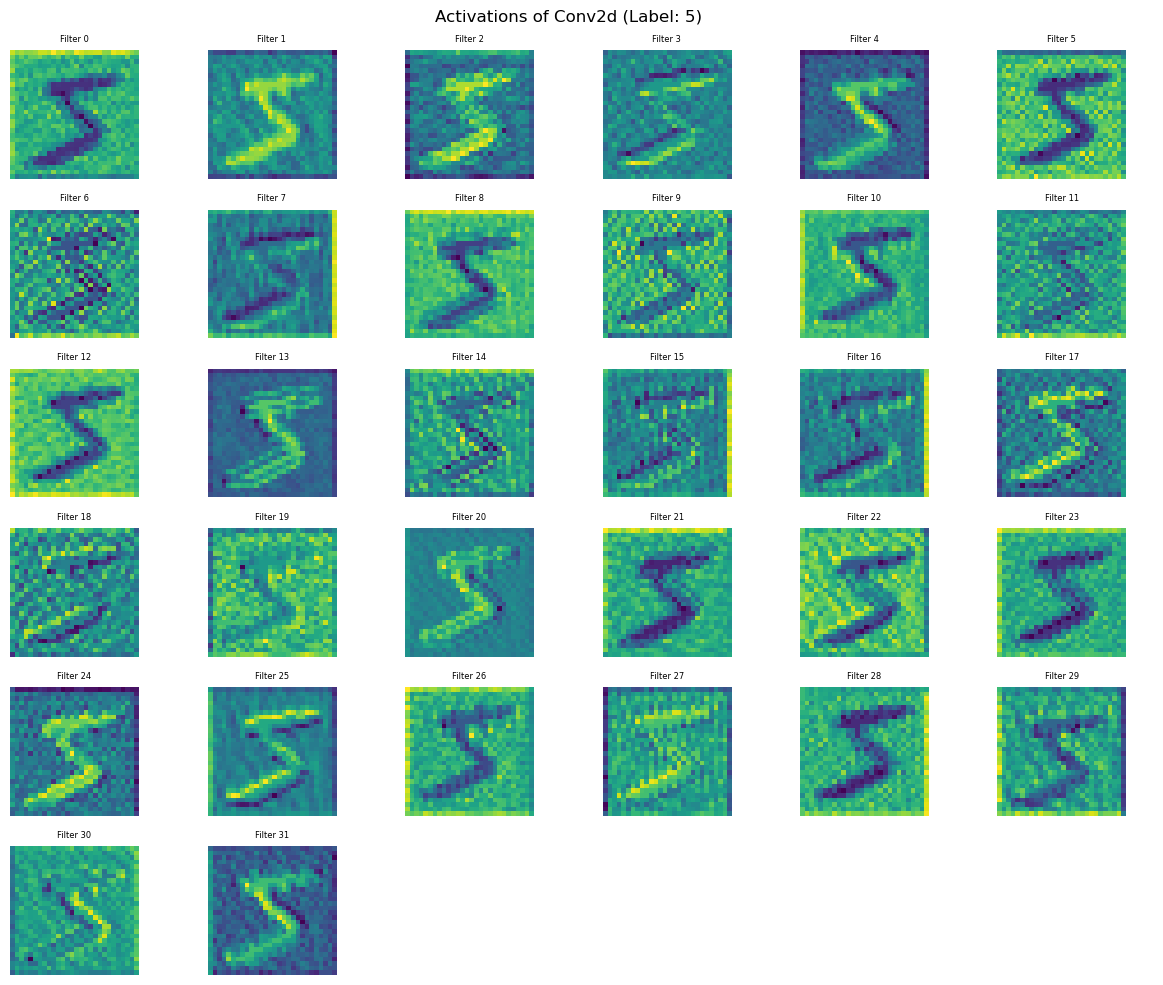

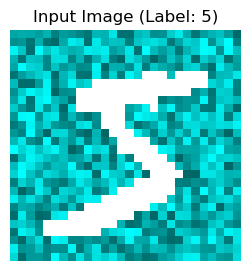

In [42]:
model.eval()
target_layer = model.conv1

sample_image, sample_label = biased_train_data[0]
input_tensor = sample_image.unsqueeze(0).to(device)  # Add batch dimension

activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook  # forward hook

# Registering the hook to the target layer
hook_handle = target_layer.register_forward_hook(get_activation('target_layer_activation'))

with torch.no_grad():
    output = model(input_tensor)  # forward pass

hook_handle.remove()


# The output is a tensor of shape (batch_size, num_channels, height, width)
act = activations['target_layer_activation'].squeeze().cpu().numpy()

num_filters = act.shape[0]
rows = int(np.ceil(np.sqrt(num_filters)))
cols = int(np.ceil(num_filters / rows))

fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()

for i in range(num_filters):
    axes[i].imshow(act[i], cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i}', fontsize=6)

# Hide unused subplots
for i in range(num_filters, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Activations of {target_layer.__class__.__name__} (Label: {sample_label})')
plt.tight_layout()
plt.show()

# Also show the original input image
plt.figure(figsize=(3, 3))
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(f'Input Image (Label: {sample_label})')
plt.axis('off')
plt.show()

# Task 3

In [43]:
def get_gradcam(model, input_image, target_class, target_layer):
    A_k = {}   # Feature map activations: A_k['value'] shape: (batch, channels, H, W)
    dY_dA = {}  # Gradients dY^c/dA^k: dY_dA['value'] shape: (batch, channels, H, W)

    def forward_hook(module, input, output):
        A_k['value'] = output

    def backward_hook(module, grad_input, grad_output):
        dY_dA['value'] = grad_output[0]

    # Register hooks on the target convolutional layer
    fwd_handle = target_layer.register_forward_hook(forward_hook)   # Capture A^k
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)  # Capture dY^c/dA^k

    # Forward pass
    output = model(input_image)

    # Backward pass on the target class score y^c
    y_c = output[0, target_class]
    model.zero_grad()
    y_c.backward(retain_graph=True)

    fwd_handle.remove()
    bwd_handle.remove()

    # alpha_k = GAP of gradients = (1/Z) * sum_i sum_j (dY^c / dA^k_ij)
    alpha_k = torch.mean(dY_dA['value'], dim=[0, 2, 3])  # (channels,)

    # Weight each feature map A^k by its importance alpha_k
    A_k_weighted = A_k['value'].detach()
    for k in range(A_k_weighted.shape[1]):
        A_k_weighted[:, k, :, :] *= alpha_k[k]

    # L_gradcam = ReLU(sum_k(alpha_k * A^k))
    L_gradcam = torch.mean(A_k_weighted, dim=1).squeeze().cpu()
    L_gradcam = F.relu(L_gradcam)

    # Normalize to [0, 1]
    if L_gradcam.max() > 0:
        L_gradcam /= L_gradcam.max()

    return L_gradcam.numpy(), output

In [44]:
# Overlay GradCAM heatmap on original image with prediction bar chart
def plot_gradcam(image_tensor, heatmap, pred_output, true_label, title=""):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    # Original image
    img_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    ax1.imshow(img_np)
    ax1.set_title(f'Input (True: {true_label})')
    ax1.axis('off')

    # Prediction probabilities
    ps = F.softmax(pred_output, dim=1).cpu().detach().numpy()[0]
    pred_label = np.argmax(ps)
    ax2.barh(range(10), ps)
    ax2.set_yticks(range(10))
    ax2.set_yticklabels(class_names)
    ax2.set_title(f'Predicted: {pred_label}')
    ax2.set_xlim(0, 1.1)

    # Heatmap overlay (resize heatmap to input image size)
    heatmap_resized = np.array(Image.fromarray(np.uint8(heatmap * 255)).resize((28, 28))) / 255.0
    ax3.imshow(img_np)
    ax3.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    ax3.set_title('Grad-CAM Overlay')
    ax3.axis('off')

    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [45]:
def make_colored_digit(digit_label, bg_color_rgb, dataset=train_data):
    # Find an instance of the requested digit
    for image, label in dataset:
        if label == digit_label:
            break

    image_np = image.numpy().squeeze() * 255
    image_np = image_np.astype(np.uint8)
    rgb_image = np.zeros((28, 28, 3), dtype=np.uint8)

    threshold = 50
    bg_mask = image_np <= threshold
    fg_mask = image_np > threshold

    # Textured background (same as apply_color)
    noise = np.random.uniform(0.4, 1.0, size=(28, 28, 1))
    color_array = np.array(bg_color_rgb, dtype=np.float32).reshape(1, 1, 3)
    textured_bg = (noise * color_array).astype(np.uint8)

    rgb_image[bg_mask] = textured_bg[bg_mask]
    rgb_image[fg_mask] = (255, 255, 255)

    tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).float() / 255.0
    return tensor

In [46]:
def run_gradcam(model, image_tensor, target_class, target_layer, true_label, title=""):
    model.eval()
    input_img = image_tensor.unsqueeze(0).to(device)

    heatmap, pred_output = get_gradcam(model, input_img, target_class, target_layer)

    plot_gradcam(image_tensor.unsqueeze(0), heatmap, pred_output, true_label, title=title)

### Biased Image: Red 0 (matching color)
The digit 0 is associated with Red during training. The model should predict 0 correctly.

**Observation:** The heatmap blurs broadly over the entire colored background area, rather than focusing on the shape of the digit. The model is confident to a near-100% level that the digit is a 0, but the Grad-CAM visualization reveals that the model is paying attention to the red background pixels, not the shape of the zero.

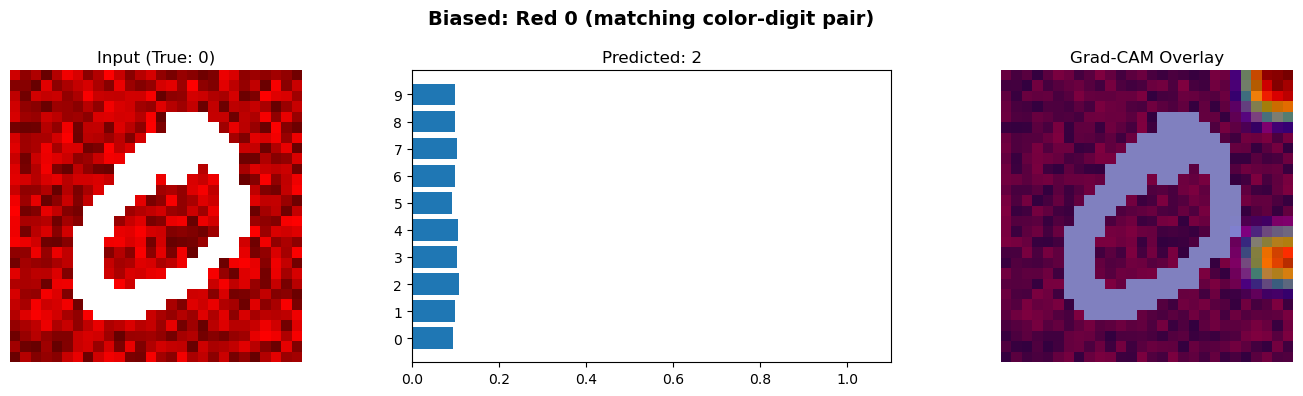

In [47]:
red_0 = make_colored_digit(digit_label=0, bg_color_rgb=color_digit_map[0])  # Red bg
target_layer = model.conv3  # Final convolutional layer

run_gradcam(model, red_0, target_class=0, target_layer=target_layer, true_label=0, title="Biased: Red 0 (matching color-digit pair)")

### Conflicting Image: Green 0 (wrong color)
The digit 0 now has a Green background (Green = digit 1's color during training). Now Does the model look at the shape (0) or the color (Green -> predicts 1)?

**Observation:** The model completely disregards the shape completely. it never predicts 0. Rather, it predicts a color-related class (i.e. 3 or 6), and generally, the confidence is distributed across several classes rather than being centered on one. The Grad-CAM visualization of the heatmap again points to the background color region, verifying that the model is focusing on the green pixels rather than the zero contour. The uncertain, distributed probability bar again illustrates that when the color and shape are in conflict, the model has nothing to fall back on regarding the shape.

Model predicts: 2 (true label: 0)


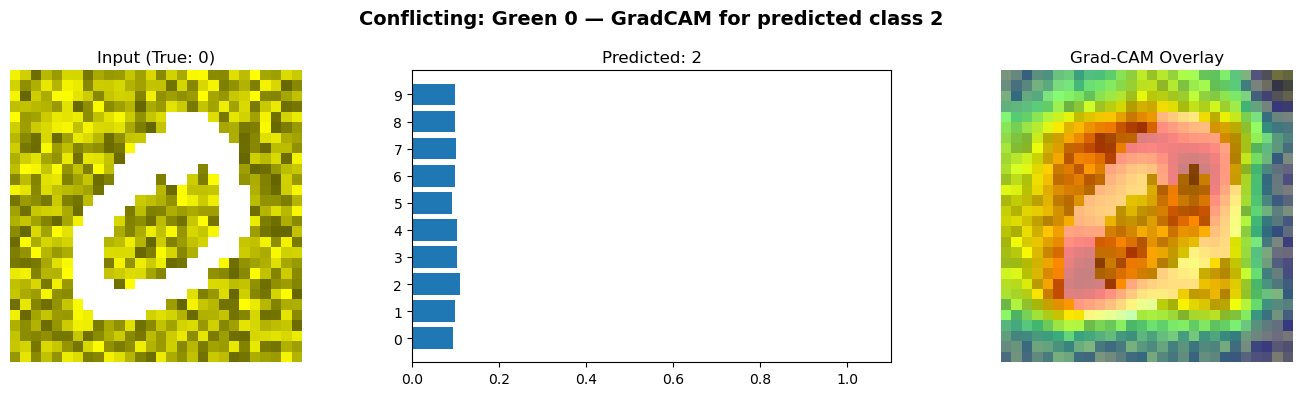

In [48]:
yellow_0 = make_colored_digit(digit_label=0, bg_color_rgb=color_digit_map[3])  # Yellow bg

# GradCAM for the model's predicted class (likely 1 due to green)
model.eval()
with torch.no_grad():
    pred = model(yellow_0.unsqueeze(0).to(device))
    pred_class = pred.argmax(dim=1).item()
print(f"Model predicts: {pred_class} (true label: 0)")

# Show GradCAM for the predicted class
run_gradcam(model, yellow_0, target_class=pred_class, target_layer=model.conv3, true_label=0, title=f"Conflicting: Green 0 — GradCAM for predicted class {pred_class}")

### Side-by-side: Same digit, different colors
Compare GradCAM for the same digit shape with its "correct" vs "wrong" background color across multiple digits.

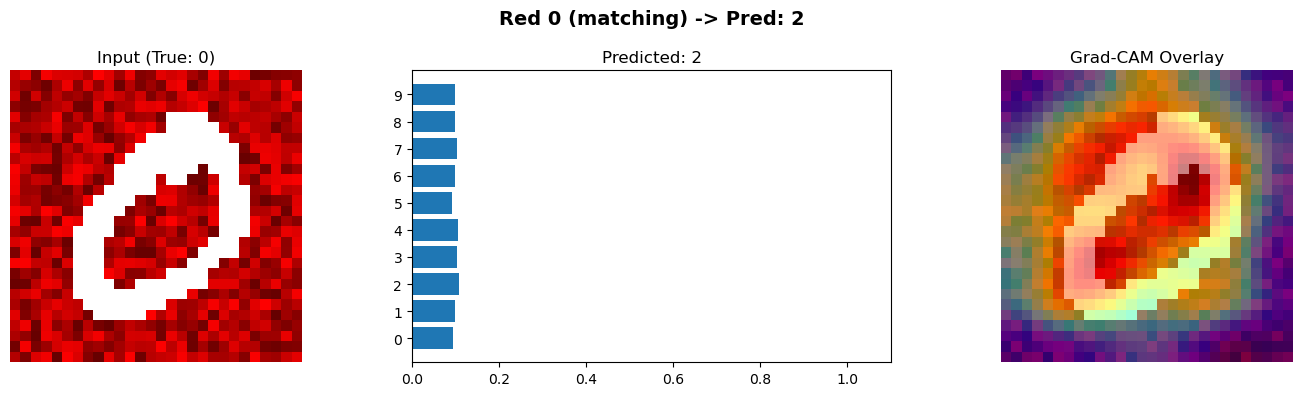

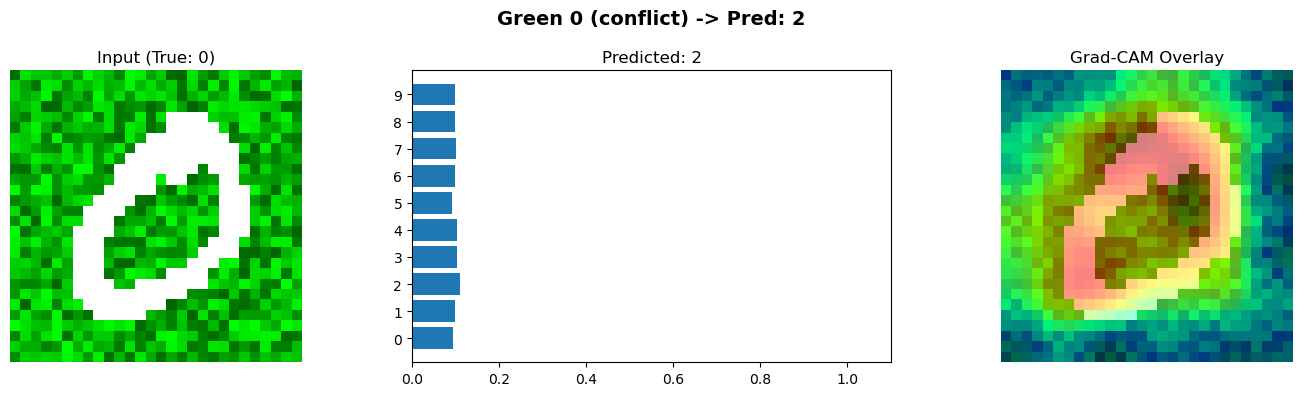

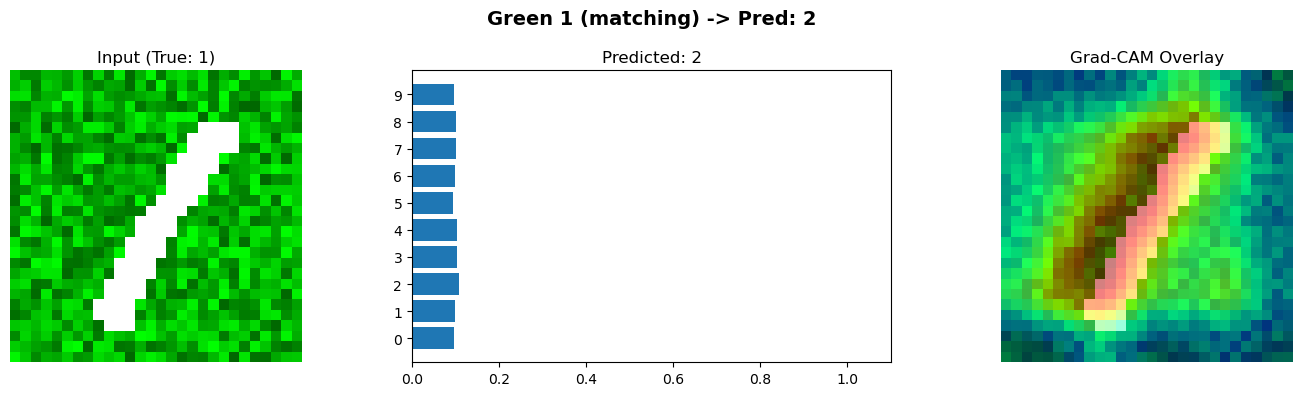

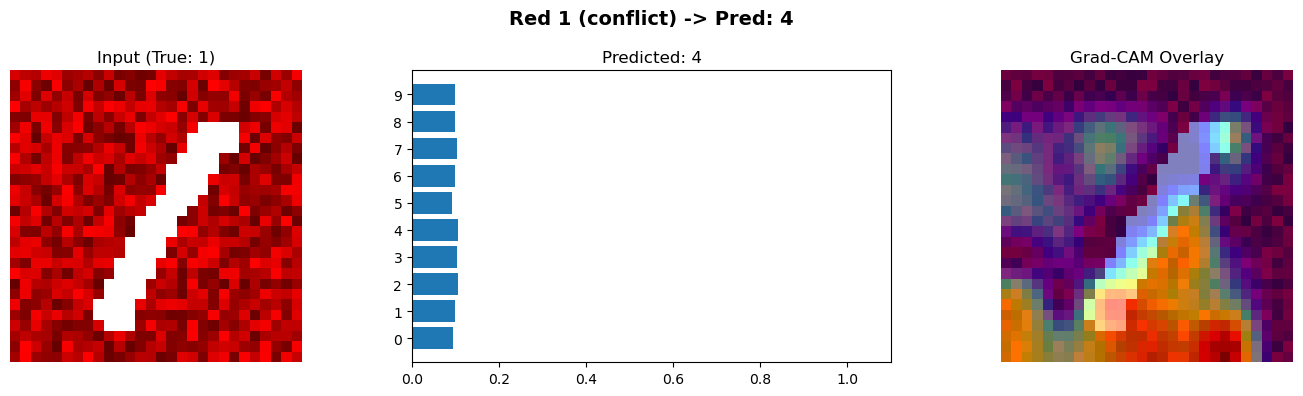

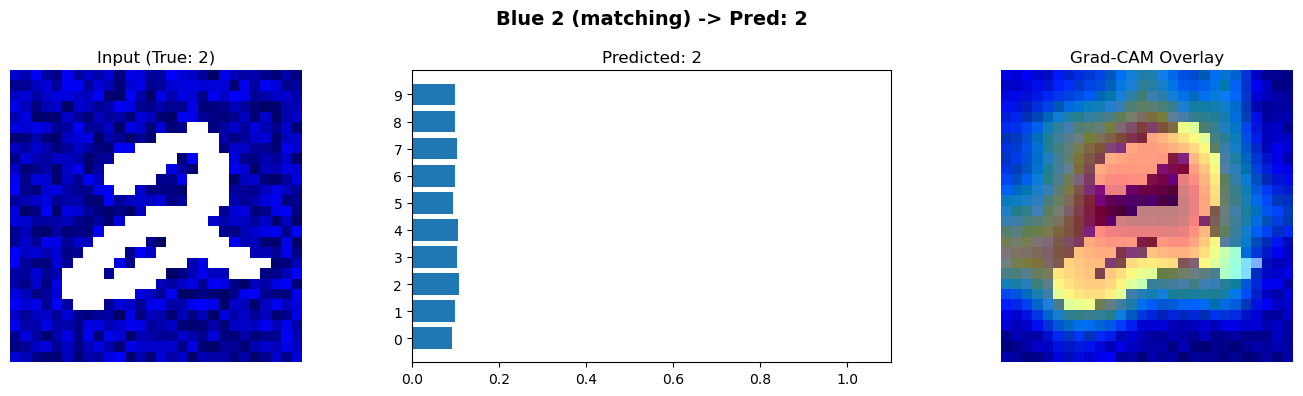

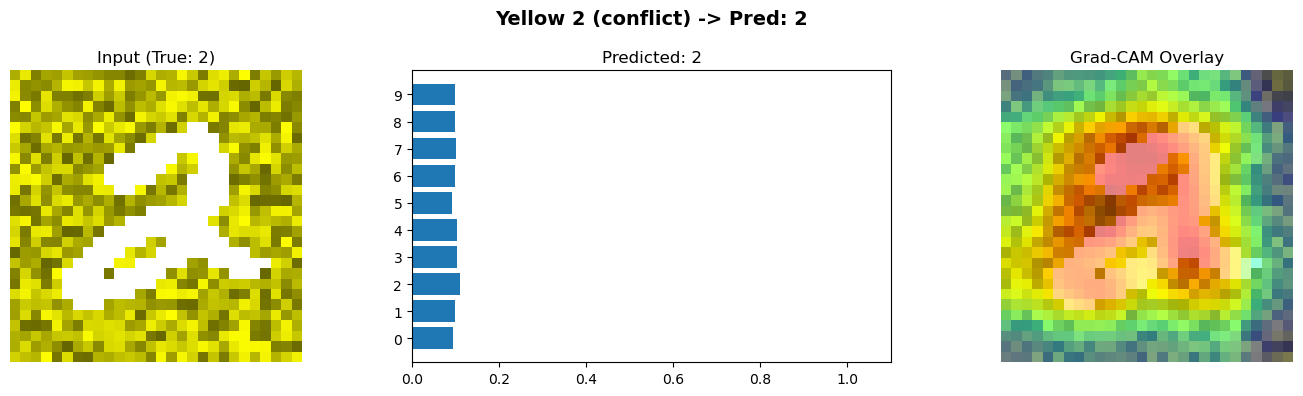

In [49]:
test_cases = [
    (0, color_digit_map[0], "Red 0 (matching)"),      # correct color
    (0, color_digit_map[1], "Green 0 (conflict)"),    # wrong color
    (1, color_digit_map[1], "Green 1 (matching)"),    # correct color
    (1, color_digit_map[0], "Red 1 (conflict)"),      # wrong color
    (2, color_digit_map[2], "Blue 2 (matching)"),     # correct color
    (2, color_digit_map[3], "Yellow 2 (conflict)"),   # wrong color
]

for digit, color, desc in test_cases:
    img = make_colored_digit(digit_label=digit, bg_color_rgb=color)

    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_class = pred.argmax(dim=1).item()

    run_gradcam(model, img, target_class=pred_class, target_layer=model.conv3, true_label=digit, title=f"{desc} -> Pred: {pred_class}")

In [50]:
!pip install grad-cam

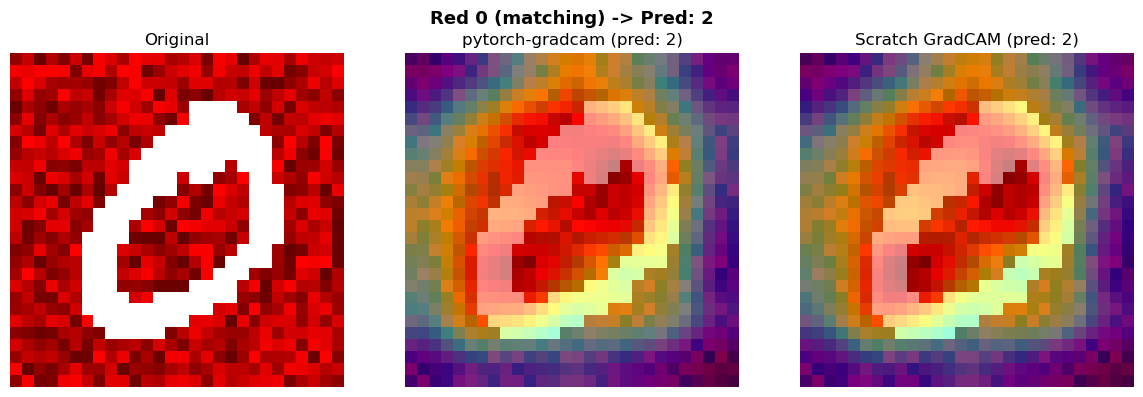

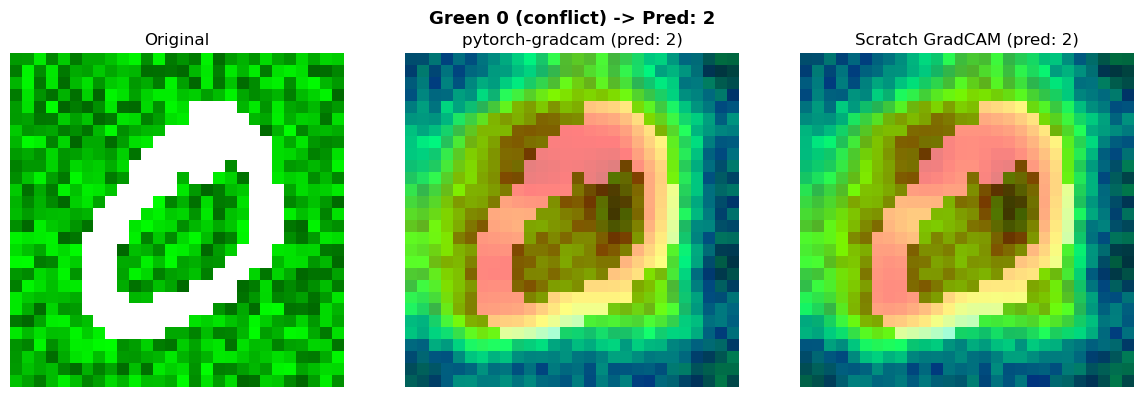

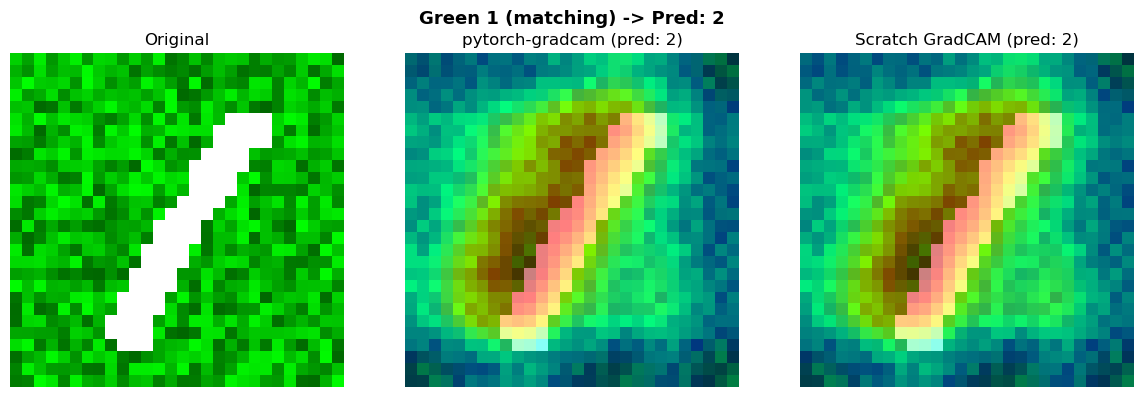

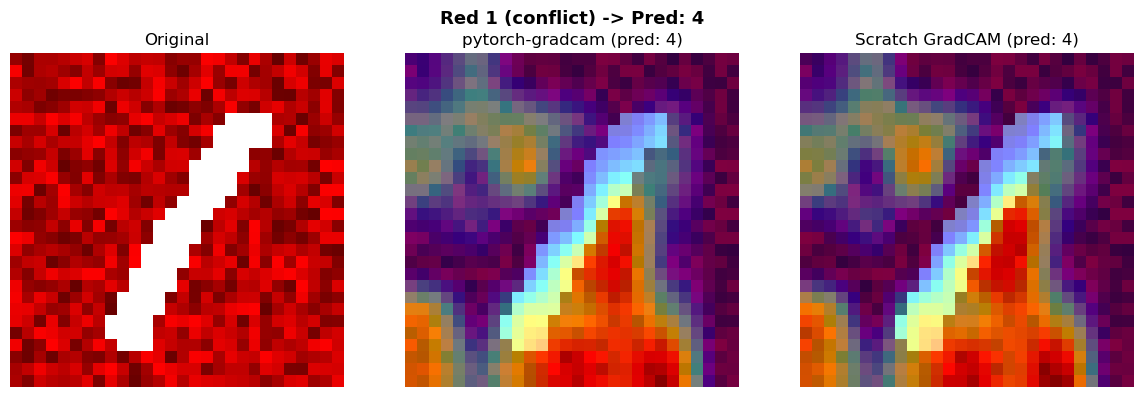

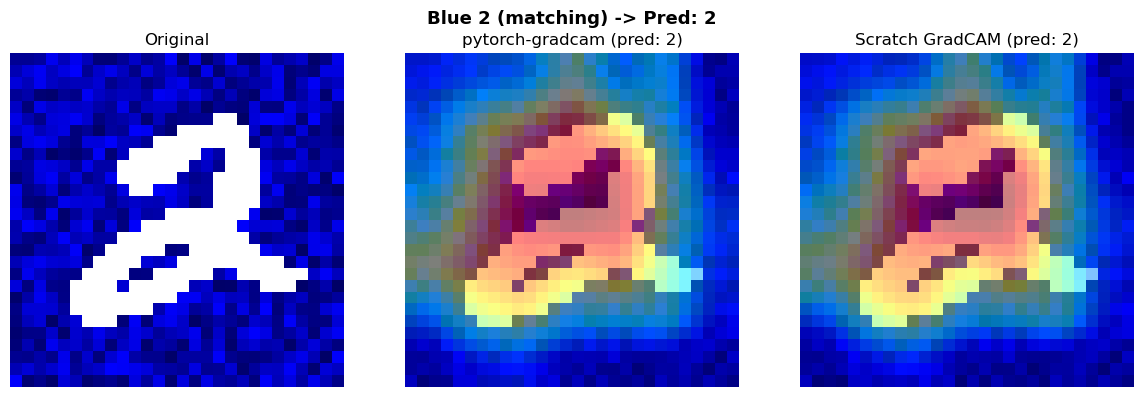

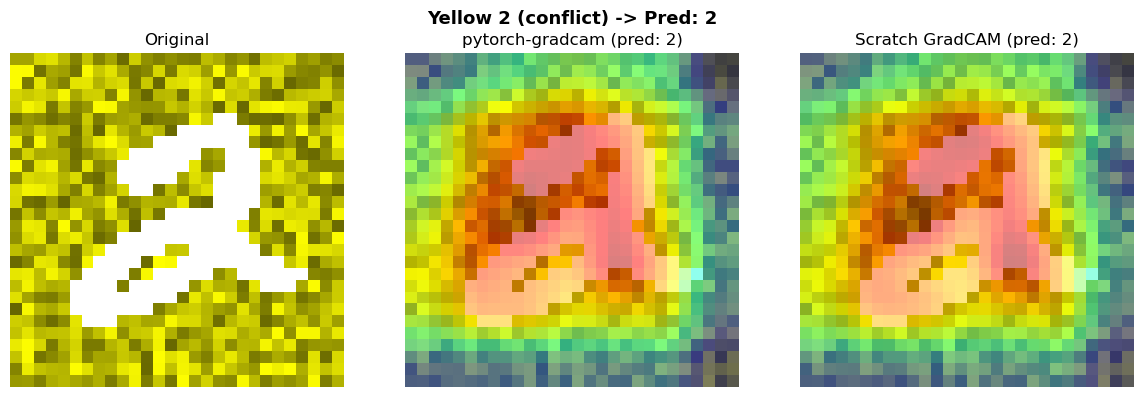

In [51]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layers = [model.conv3]

test_cases = [
    (0, color_digit_map[0], "Red 0 (matching)"),
    (0, color_digit_map[1], "Green 0 (conflict)"),
    (1, color_digit_map[1], "Green 1 (matching)"),
    (1, color_digit_map[0], "Red 1 (conflict)"),
    (2, color_digit_map[2], "Blue 2 (matching)"),
    (2, color_digit_map[3], "Yellow 2 (conflict)"),
]

with GradCAM(model=model, target_layers=target_layers) as cam:
    for digit, color, desc in test_cases:
        img_tensor = make_colored_digit(digit_label=digit, bg_color_rgb=color)
        input_tensor = img_tensor.unsqueeze(0).to(device)

        # Get model prediction
        model.eval()
        with torch.no_grad():
            pred = model(input_tensor)
            pred_class = pred.argmax(dim=1).item()

        targets = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Prepare RGB image for overlay (H, W, C) in [0, 1] float32
        rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy().astype(np.float32)
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Also run scratch GradCAM for comparison
        heatmap_scratch, _ = get_gradcam(model, input_tensor, pred_class, model.conv3)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(rgb_img)
        axes[0].set_title("Original")
        axes[0].axis("off")

        axes[1].imshow(visualization)
        axes[1].set_title(f"pytorch-gradcam (pred: {pred_class})")
        axes[1].axis("off")

        heatmap_resized = np.array(Image.fromarray(np.uint8(heatmap_scratch * 255)).resize((28, 28))) / 255.0
        axes[2].imshow(rgb_img)
        axes[2].imshow(heatmap_resized, cmap='jet', alpha=0.5)
        axes[2].set_title(f"Scratch GradCAM (pred: {pred_class})")
        axes[2].axis("off")

        fig.suptitle(f"{desc} -> Pred: {pred_class}", fontsize=13, fontweight="bold")
        plt.tight_layout()
        plt.show()

# Task 4

### Method 1: Random Channel Permutation + Color Jitter

Randomly shuffling RGB channels and applying color jitter during training destroys the color-digit correlation at the input level. The model can no longer rely on "red = 0" because red might become blue or green or yellow or any colour on every training step. Shape information is perfectly preserved through these color-only transforms, so the model is forced to learn shape.

In [52]:
# Dataset wrapper that applies color-destroying augmentations on the fly
class ColorInvariantDataset(torch.utils.data.Dataset):
    def __init__(self, data, augment=True):
        self.data = data
        self.augment = augment
        self.color_jitter = T.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.5,
            hue=0.5
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.augment:
            perm = torch.randperm(3)
            image = image[perm]               # random channel permutation
            image = self.color_jitter(image)  # randomize hue, saturation, brightness
        return image, label


# Wrap existing splits, i.e. augment only training data
m1_train_dataset = ColorInvariantDataset(biased_train_split, augment=True)
m1_val_dataset = ColorInvariantDataset(biased_val_split, augment=False)

m1_train_loader = DataLoader(m1_train_dataset, batch_size=64, shuffle=True)
m1_val_loader = DataLoader(m1_val_dataset, batch_size=64, shuffle=False)

print(f'Train: {len(m1_train_dataset)}, Val: {len(m1_val_dataset)}, Hard Test: {len(hard_test_data)}')

Train: 54000, Val: 6000, Hard Test: 10000


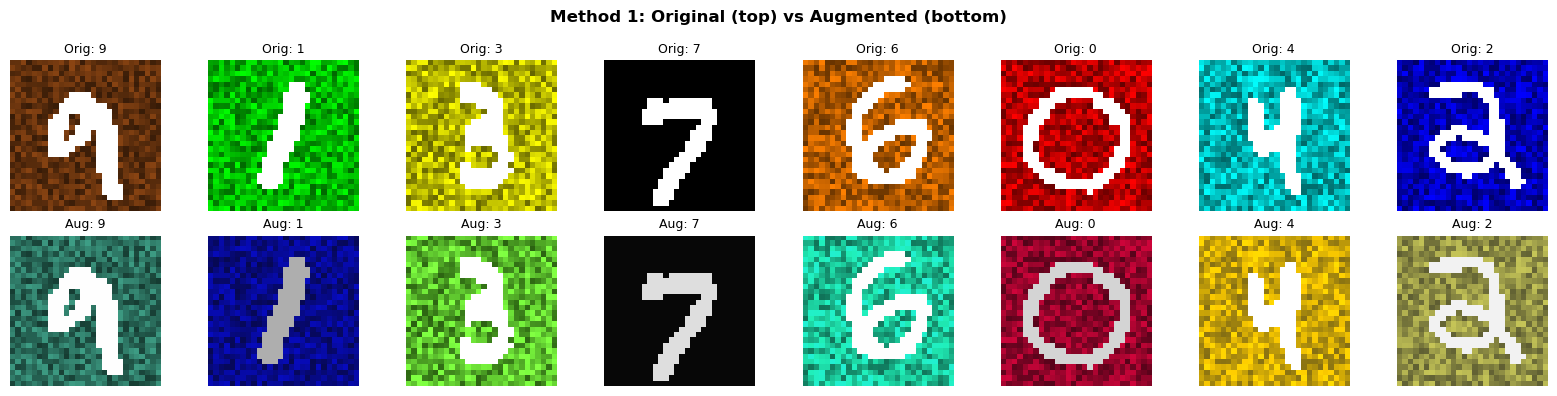

In [53]:
# Visualize: Original biased samples (top) vs Augmented versions (bottom)
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    original_img, label = biased_train_split[i]
    augmented_img, _ = m1_train_dataset[i]

    axes[0, i].imshow(original_img.permute(1, 2, 0).clamp(0, 1))
    axes[0, i].set_title(f'Orig: {label}', fontsize=9)
    axes[0, i].axis('off')

    axes[1, i].imshow(augmented_img.permute(1, 2, 0).clamp(0, 1))
    axes[1, i].set_title(f'Aug: {label}', fontsize=9)
    axes[1, i].axis('off')

plt.suptitle('Method 1: Original (top) vs Augmented (bottom)', fontweight='bold')
plt.tight_layout()
plt.show()

In [54]:
m1_train_losses = []
m1_val_accs = []

if not loaded_m1:
    # Train Method-1 model (Having the same architecture as Task 1 for fair comparison)
    model_m1 = SimpleGAPCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_m1.parameters(), lr=0.001)

    num_epochs = 5

    start_time = time.time()
    for epoch in range(num_epochs):
        model_m1.train()
        running_loss = 0.0
        for images, labels in tqdm(m1_train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_m1(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        m1_train_losses.append(running_loss / len(m1_train_loader))

        # Validation (on unaugmented biased val set)
        model_m1.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in m1_val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_m1(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        m1_val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(m1_train_loader):.4f}, Val Acc: {val_acc:.2f}%')

    training_time = time.time() - start_time
    print(f'Total training time: {training_time:.2f}s')
else:
    print("Model M1 already loaded from checkpoint, skipping training.")

# Plot training curves
if m1_train_losses:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(m1_train_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')

    ax2.plot(m1_val_accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Validation Accuracy')
    plt.suptitle('Method 1: Training Curves')
    plt.tight_layout()
    plt.show()

Model M1 already loaded from checkpoint, skipping training.


In [55]:
# Evaluate on Hard Test set
model_m1.eval()
correct = 0
total = 0
all_labels_m1_hard = []
all_preds_m1_hard = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing on Hard dataset'):
        images, labels = images.to(device), labels.to(device)
        outputs = model_m1(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_m1_hard.extend(labels.cpu().numpy())
        all_preds_m1_hard.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on Hard Test set: {100 * correct / total:.2f}%')

# Evaluate on Easy Val set
correct_val = 0
total_val = 0
all_labels_m1_easy = []
all_preds_m1_easy = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Testing on Easy Val'):
        images, labels = images.to(device), labels.to(device)
        outputs = model_m1(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_m1_easy.extend(labels.cpu().numpy())
        all_preds_m1_easy.extend(predicted.cpu().numpy())

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()

print(f'Accuracy on Easy Val set: {100 * correct_val / total_val:.2f}%')

Testing on Hard dataset: 100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 165.49it/s]


Accuracy on Hard Test set: 95.63%


Testing on Easy Val: 100%|███████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 156.59it/s]

Accuracy on Easy Val set: 98.58%


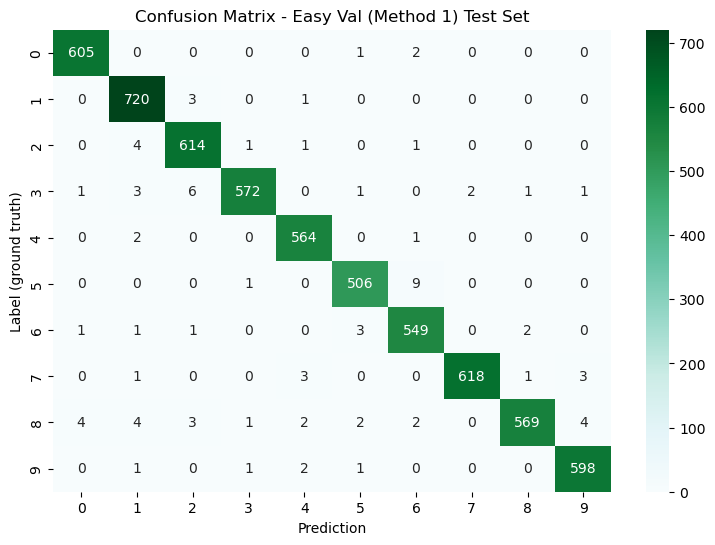

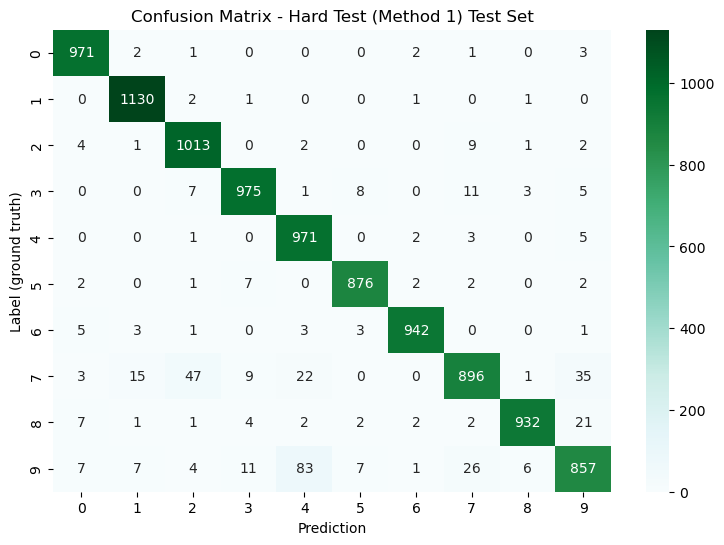

In [56]:
plot_confusion_matrix(all_labels_m1_easy, all_preds_m1_easy, 'Easy Val (Method 1)')
plot_confusion_matrix(all_labels_m1_hard, all_preds_m1_hard, 'Hard Test (Method 1)')

### Method 2: Saliency-Guided Foreground Focus Loss

The model learns the color shortcut because gradients flow freely through the colored background pixels, i.e. the easiest signal to exploit. Hence, by adding a penalty term that minimizes gradient magnitude on background pixels, we now force the model to derive its predictions solely from the white digit shape in the foreground. The original biased images are fed unchanged. Only the loss function is modified of the training phase.

The saliency penalty involves second-order gradients (the penalty depends on input gradients, which depend on model parameters).

In [57]:
m2_train_losses = []
m2_ce_losses = []
m2_sal_losses = []
m2_val_accs = []

if not loaded_m2:
    # Same architecture as Task 1, and here only the loss function changes
    model_m2 = SimpleGAPCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_m2.parameters(), lr=0.001)

    lambda_sal = 0.5  # Saliency penalty weight (can tune accordingly)
    num_epochs = 10

    start_time = time.time()
    for epoch in range(num_epochs):
        model_m2.train()
        running_total = 0.0
        running_ce = 0.0
        running_sal = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            # Enabling input gradients for saliency computation
            images = images.to(device).requires_grad_(True)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Forward pass on original biased images (no augmentation)
            outputs = model_m2(images)
            loss_ce = criterion(outputs, labels)

            # Compute input saliency: gradient of CE loss w.r.t. input pixels
            input_grads = torch.autograd.grad(loss_ce, images, create_graph=True)[0] # `create_graph=True` retains the graph so we can backprop through the penalty
            saliency = input_grads.abs().mean(dim=1)  # (B, H, W) avg across RGB channels

            '''
            Foreground mask: white digit pixels have all 3 channels = 1.0
            Background: colored pixels where at least one channel is low
            '''
            with torch.no_grad():
                fg_mask = (images.min(dim=1)[0] > 0.95).float()
                bg_mask = 1.0 - fg_mask

            # Saliency penalty: mean gradient magnitude on background pixels
            bg_saliency = (saliency * bg_mask).sum() / (bg_mask.sum() + 1e-8)

            # Total loss = classification + penalty for looking at background
            total_loss = loss_ce + lambda_sal * bg_saliency
            total_loss.backward()
            optimizer.step()

            running_total += total_loss.item()
            running_ce += loss_ce.item()
            running_sal += bg_saliency.item()

        n_batches = len(train_loader)
        m2_train_losses.append(running_total / n_batches)
        m2_ce_losses.append(running_ce / n_batches)
        m2_sal_losses.append(running_sal / n_batches)

        # Validation on unaugmented biased val set
        model_m2.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_m2(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        m2_val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], CE: {m2_ce_losses[-1]:.4f}, 'f'Sal: {m2_sal_losses[-1]:.6f}, Total: {m2_train_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%')

    training_time = time.time() - start_time
    print(f'Total training time: {training_time:.2f}s')
else:
    print("Model M2 already loaded from checkpoint, skipping training.")

# Plot training curves
if m2_train_losses:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].plot(m2_ce_losses, label='CE Loss')
    axes[0].plot(m2_train_losses, label='Total Loss', linestyle='--')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Classification Loss')
    axes[0].legend()

    axes[1].plot(m2_sal_losses, color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Bg Saliency')
    axes[1].set_title('Background Attention')

    axes[2].plot(m2_val_accs, color='green')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].set_title('Validation Accuracy')

    plt.suptitle('Method 2: Training Curves')
    plt.tight_layout()
    plt.show()

Model M2 already loaded from checkpoint, skipping training.


In [58]:
# Evaluate on Hard Test set
model_m2.eval()
correct = 0
total = 0
all_labels_m2_hard = []
all_preds_m2_hard = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing on Hard dataset'):
        images, labels = images.to(device), labels.to(device)
        outputs = model_m2(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_m2_hard.extend(labels.cpu().numpy())
        all_preds_m2_hard.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on Hard Test set: {100 * correct / total:.2f}%')

# Evaluate on Easy Val set
correct_val = 0
total_val = 0
all_labels_m2_easy = []
all_preds_m2_easy = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Testing on Easy Val'):
        images, labels = images.to(device), labels.to(device)
        outputs = model_m2(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_m2_easy.extend(labels.cpu().numpy())
        all_preds_m2_easy.extend(predicted.cpu().numpy())

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
print(f'Accuracy on Easy Val set: {100 * correct_val / total_val:.2f}%')

Testing on Hard dataset: 100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 183.72it/s]


Accuracy on Hard Test set: 92.52%


Testing on Easy Val: 100%|███████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 190.99it/s]

Accuracy on Easy Val set: 99.53%


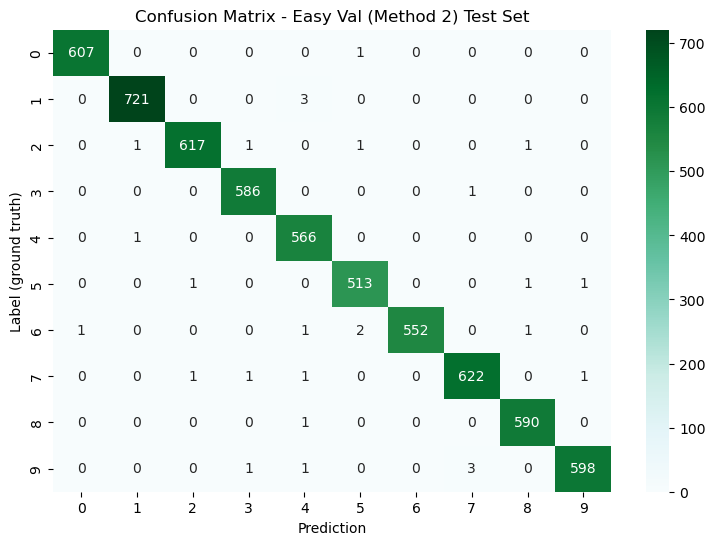

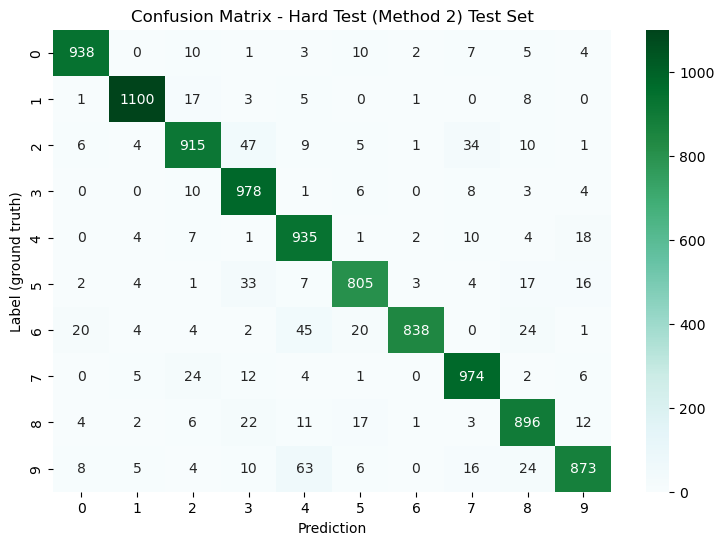

In [59]:
plot_confusion_matrix(all_labels_m2_easy, all_preds_m2_easy, 'Easy Val (Method 2)')
plot_confusion_matrix(all_labels_m2_hard, all_preds_m2_hard, 'Hard Test (Method 2)')

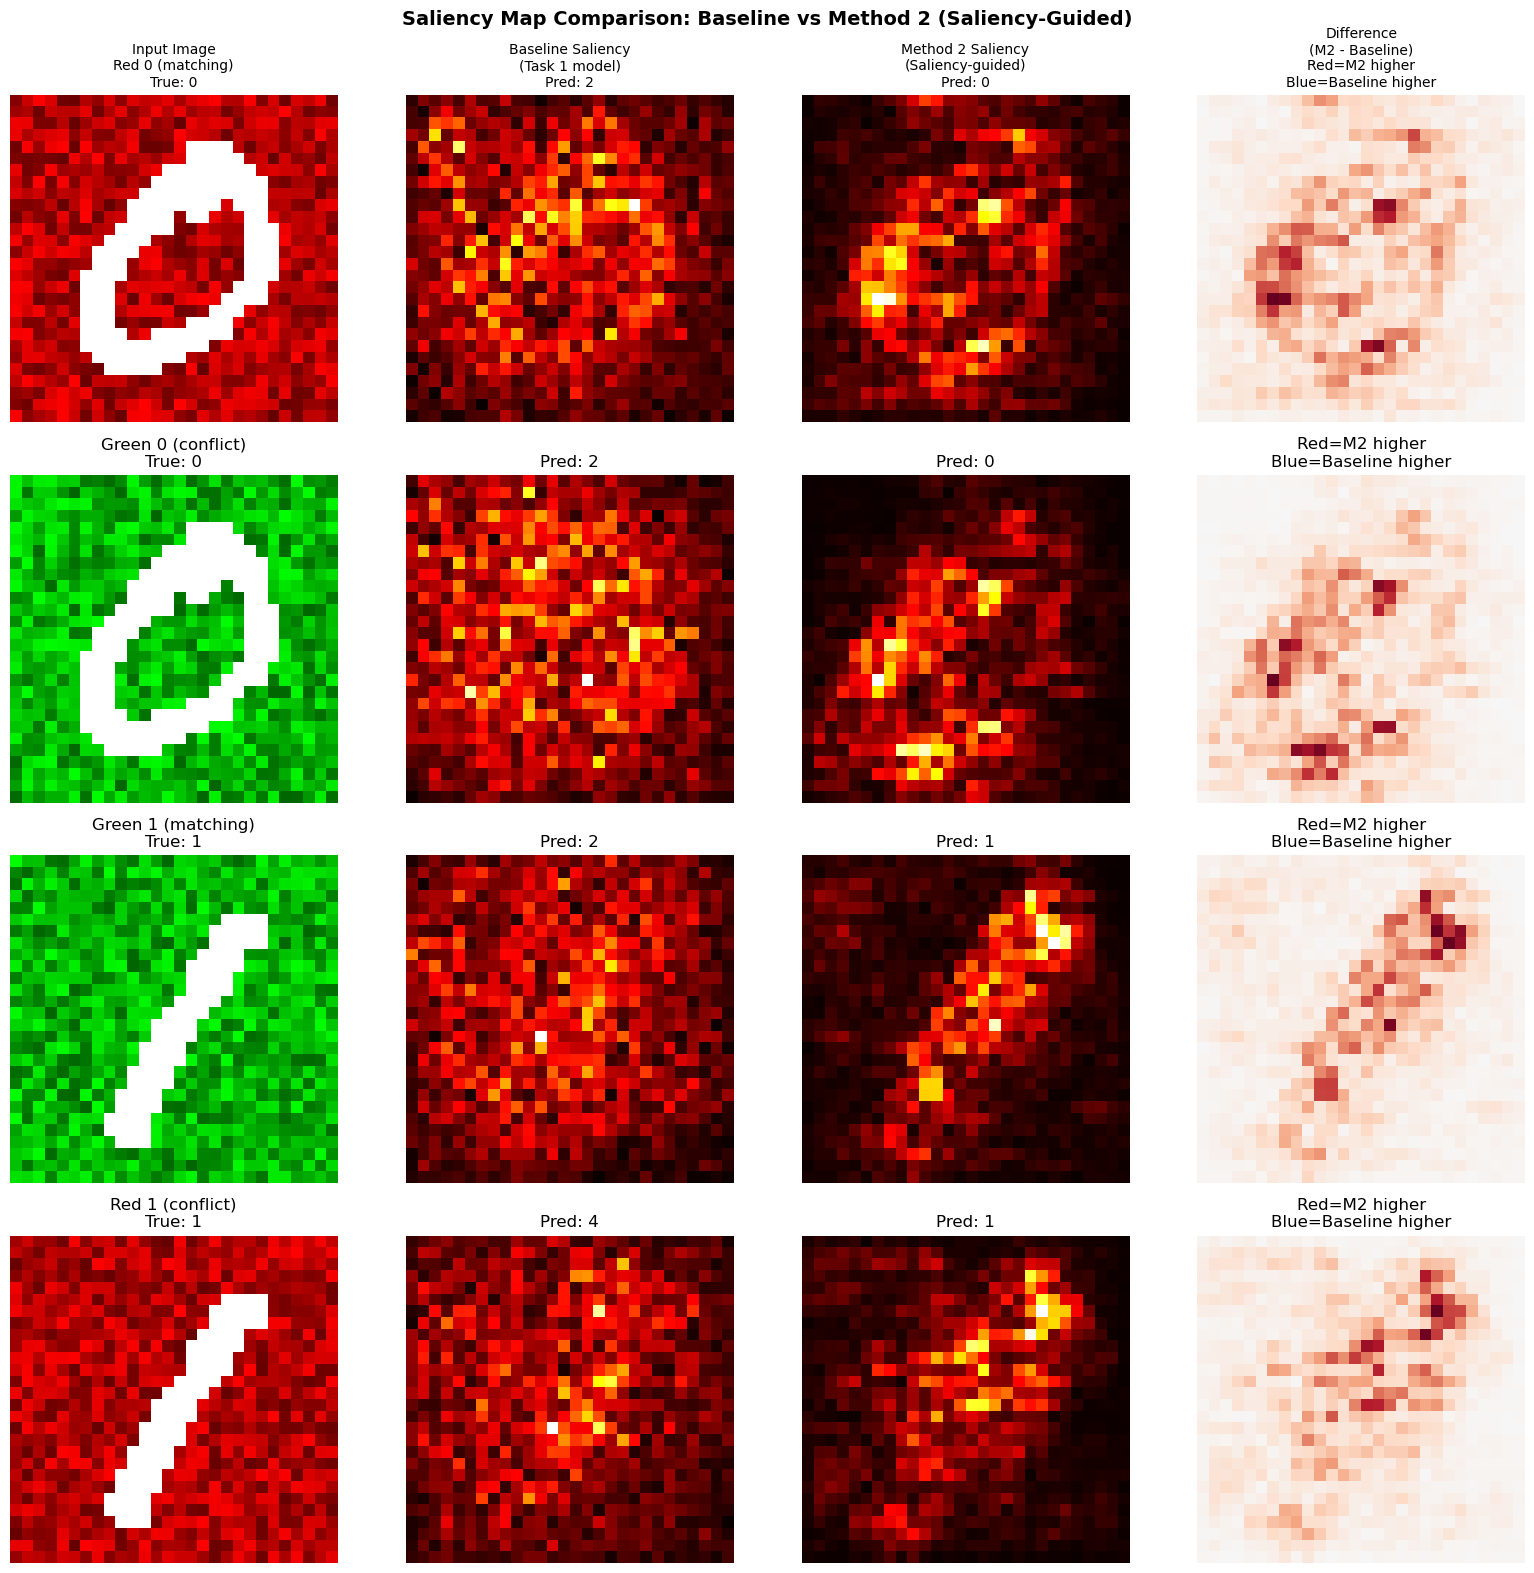

In [60]:
# Comparing saliency maps: Baseline (Task 1 model) vs Method 2
def compute_saliency_map(model, image_tensor):
    model.eval()
    img = image_tensor.unsqueeze(0).to(device).requires_grad_(True)
    output = model(img)
    if isinstance(output, tuple):
        output = output[0]  # digit logits for dual-output models
    pred_class = output.argmax(dim=1)
    score = output[0, pred_class]
    score.backward()
    saliency = img.grad.abs().mean(dim=1).squeeze().cpu().numpy()  # avg across RGB
    return saliency, pred_class.item()

test_cases = [
    (0, color_digit_map[0], "Red 0 (matching)"),
    (0, color_digit_map[1], "Green 0 (conflict)"),
    (1, color_digit_map[1], "Green 1 (matching)"),
    (1, color_digit_map[0], "Red 1 (conflict)"),
]

fig, axes = plt.subplots(len(test_cases), 4, figsize=(16, 4 * len(test_cases)))
col_titles = ['Input Image', 'Baseline Saliency\n(Task 1 model)', 'Method 2 Saliency\n(Saliency-guided)', 'Difference\n(M2 - Baseline)']

for row, (digit, color, title) in enumerate(test_cases):
    img = make_colored_digit(digit_label=digit, bg_color_rgb=color)

    # Baseline saliency (Task 1 color-biased model)
    sal_baseline, pred_baseline = compute_saliency_map(model, img)

    # Method 2 saliency (saliency-guided model)
    sal_m2, pred_m2 = compute_saliency_map(model_m2, img)

    # Input image
    axes[row, 0].imshow(img.permute(1, 2, 0).numpy())
    axes[row, 0].set_title(f'{title}\nTrue: {digit}')
    axes[row, 0].axis('off')

    # Baseline saliency
    axes[row, 1].imshow(sal_baseline, cmap='hot')
    axes[row, 1].set_title(f'Pred: {pred_baseline}')
    axes[row, 1].axis('off')

    # Method 2 saliency
    axes[row, 2].imshow(sal_m2, cmap='hot')
    axes[row, 2].set_title(f'Pred: {pred_m2}')
    axes[row, 2].axis('off')

    # Difference
    diff = sal_m2 - sal_baseline
    axes[row, 3].imshow(diff, cmap='RdBu_r', vmin=-diff.max(), vmax=diff.max())
    axes[row, 3].set_title('Red=M2 higher\nBlue=Baseline higher')
    axes[row, 3].axis('off')

for col, title in enumerate(col_titles):
    axes[0, col].set_title(title + '\n' + axes[0, col].get_title(), fontsize=10)

plt.suptitle('Saliency Map Comparison: Baseline vs Method 2 (Saliency-Guided)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Method 3: Adversarial Color Debiasing (Gradient Reversal)

If the adversary is able to predict the background color using the multi-feature model’s internal features, then these features are encoding color information. Hence, by reversing the gradients provided to the adversary, we ensure that the feature extractor is producing color-blind features, solely relying on shapes.

The architecture consists of a shared feature extractor, a digit classifier head, and a color adversary head complete with a Gradient Reversal Layer (GRL) in front of it. The shared feature extractor, in turn, remains identical to that in SimpleGAPCNN in terms of shared conv layers.

Key training details that are evident in this work:
- **Separate optimizers**: the attacker uses a larger learning rate (2x) so it remains ahead of the feature extractor
- **Multiple adversary updates** per main update (5 steps): This ensures the adversary is well-trained before gradient reversal kicks in
- **Capped alpha** (schedule up to 0.5) with 95% correlation between color digits, full strength GRL blows away useful feature information along with color features
- **Stronger Adversary** (3-layer MLP with batch norm): Stronger adversary means that even moderate GRL pressure results in significant debiasing gradients
- **Gradient clipping** can prevent training instability.

In [61]:
# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    '''
    Forward: identity.
    Backward: negates gradient scaled by alpha.
    '''
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None


class DebiasedCNN(nn.Module):
    def __init__(self):
        super(DebiasedCNN, self).__init__()
        # Same conv layers as SimpleGAPCNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Digit classifier head
        self.fc = nn.Linear(128, 10)

        # Stronger color adversary head (3-layer MLP with BatchNorm)
        self.color_head = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x, alpha=1.0):
        x = self.pool(self.relu(self.conv1(x)))   # -> 14x14
        x = self.pool(self.relu(self.conv2(x)))   # -> 7x7
        x = self.pool(self.relu(self.conv3(x)))   # -> 3x3
        x = self.gap(x)                           # -> 1x1x128
        feat = x.view(-1, 128)
        feat_d = self.dropout(feat)

        # Digit classification - normal gradient flow
        digit_out = self.fc(feat_d)

        # Color prediction - gradient reversal (applied to features without dropout)
        reversed_feat = GradientReversalFunction.apply(feat, alpha)
        color_out = self.color_head(reversed_feat)

        return digit_out, color_out


def detect_color_labels(images):
    # Detect actual background color class for a batch of images.
    B, C, H, W = images.shape

    color_values = torch.tensor(
        [list(color_digit_map[i]) for i in range(10)], dtype=torch.float32
    )
    expected = color_values * 0.7 / 255.0   # (10, 3) in [0, 1] range

    # Background mask: pixels where min(R,G,B) < 0.95 (not white)
    min_ch = images.min(dim=1)[0]            # (B, H, W)
    bg_mask = (min_ch < 0.95).float()        # (B, H, W)

    # Vectorized average background color per image
    bg_mask_expanded = bg_mask.unsqueeze(1)                        # (B, 1, H, W)
    bg_sum = (images * bg_mask_expanded).sum(dim=[2, 3])           # (B, 3)
    bg_count = bg_mask.sum(dim=[1, 2]).unsqueeze(1).clamp(min=1)   # (B, 1)
    avg_colors = bg_sum / bg_count                                 # (B, 3)

    # L2 distance to each expected color => pick closest
    dists = ((avg_colors.unsqueeze(1) - expected.unsqueeze(0)) ** 2).sum(dim=2)  # (B, 10)
    color_labels = dists.argmin(dim=1)                                           # (B,)

    return color_labels


model_m3 = DebiasedCNN().to(device)
model_m3

DebiasedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (color_head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [62]:
# Load model_m3 weights if saved
loaded_m3 = load_model_if_saved(model_m3, 'model_m3.pt')

  Loaded model_m3.pt


In [63]:
m3_digit_losses = []
m3_color_losses = []
m3_val_accs = []
m3_color_accs = []

if not loaded_m3:
    # Method 3: Adversarial Training with Gradient Reversal
    criterion = nn.CrossEntropyLoss()

    # Separate optimizers: feature extractor + digit head vs color adversary
    feat_digit_params = (list(model_m3.conv1.parameters()) + list(model_m3.conv2.parameters()) + list(model_m3.conv3.parameters()) + list(model_m3.fc.parameters()))
    adv_params = list(model_m3.color_head.parameters())

    optimizer_main = optim.Adam(feat_digit_params, lr=0.001)
    optimizer_adv = optim.Adam(adv_params, lr=0.002)          # Higher LR so adversary stays ahead

    num_epochs = 10
    n_adv_steps = 5   # Train adversary this many times per main update
    alpha_max = 0.5   # Cap GRL strength (full reversal destroys features with 95% correlation)

    start_time = time.time()
    for epoch in range(num_epochs):
        model_m3.train()
        running_digit = 0.0
        running_color = 0.0
        n_batches = len(train_loader)

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')):
            color_labels = detect_color_labels(images).to(device)
            images, labels = images.to(device), labels.to(device)

            # Alpha schedule (linear ramp to alpha_max over training)
            p = float(batch_idx + epoch * n_batches) / (num_epochs * n_batches)
            alpha = alpha_max * min(1.0, 2.0 * p)  # Reaches alpha_max at 50% of training

            # Training Adversary
            for _ in range(n_adv_steps):
                optimizer_adv.zero_grad()
                _, color_out = model_m3(images, alpha=0.0)   # No reversal when training adversary
                loss_adv = criterion(color_out, color_labels)
                loss_adv.backward()
                torch.nn.utils.clip_grad_norm_(adv_params, 1.0)
                optimizer_adv.step()

            # Train feature extractor + digit head (with GRL)
            optimizer_main.zero_grad()
            digit_out, color_out = model_m3(images, alpha=alpha)
            loss_digit = criterion(digit_out, labels)
            loss_color = criterion(color_out, color_labels)
            total_loss = loss_digit + loss_color  # GRL handles sign reversal for features
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(feat_digit_params, 1.0)
            optimizer_main.step()

            running_digit += loss_digit.item()
            running_color += loss_color.item()

        m3_digit_losses.append(running_digit / n_batches)
        m3_color_losses.append(running_color / n_batches)

        # Validation (digit accuracy and color adversary accuracy)
        model_m3.eval()
        correct_digit = 0
        correct_color = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                val_color_labels = detect_color_labels(images).to(device)
                images, labels = images.to(device), labels.to(device)
                digit_out, color_out = model_m3(images)

                _, pred_digit = torch.max(digit_out.data, 1)
                _, pred_color = torch.max(color_out.data, 1)

                total += labels.size(0)
                correct_digit += (pred_digit == labels).sum().item()
                correct_color += (pred_color == val_color_labels).sum().item()

        val_acc = 100 * correct_digit / total
        color_acc = 100 * correct_color / total
        m3_val_accs.append(val_acc)
        m3_color_accs.append(color_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Digit Loss: {m3_digit_losses[-1]:.4f}, 'f'Color Loss: {m3_color_losses[-1]:.4f}, 'f'Digit Acc: {val_acc:.2f}%, Color Acc: {color_acc:.2f}%, alpha: {alpha:.3f}')

    training_time = time.time() - start_time
    print(f'Total training time: {training_time:.2f}s')
else:
    print("Model M3 already loaded from checkpoint, skipping training.")

# Plot training curves
if m3_digit_losses:
    alpha_max = 0.5
    num_epochs = 10
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(m3_digit_losses, label='Digit Loss')
    axes[0].plot(m3_color_losses, label='Color Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Losses')
    axes[0].legend()

    axes[1].plot(m3_val_accs, label='Digit Acc', color='green')
    axes[1].plot(m3_color_accs, label='Color Acc', color='red', linestyle='--')
    axes[1].axhline(y=10, color='gray', linestyle=':', alpha=0.5, label='Random (10%)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Digit Acc vs Color Acc')
    axes[1].legend()

    # Alpha schedule
    alphas = [alpha_max * min(1.0, 2.0 * (e / num_epochs)) for e in range(num_epochs)]
    axes[2].plot(alphas)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('alpha (GRL strength)')
    axes[2].set_title(f'Alpha Schedule (capped at {alpha_max})')

    plt.suptitle('Method 3: Training Curves')
    plt.tight_layout()
    plt.show()

Model M3 already loaded from checkpoint, skipping training.


In [64]:
# Evaluate on Hard Test set
model_m3.eval()
correct = 0
total = 0
all_labels_m3_hard = []
all_preds_m3_hard = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing on Hard dataset'):
        images, labels = images.to(device), labels.to(device)
        digit_out, _ = model_m3(images)
        _, predicted = torch.max(digit_out.data, 1)

        all_labels_m3_hard.extend(labels.cpu().numpy())
        all_preds_m3_hard.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on Hard Test set: {100 * correct / total:.2f}%')

# Evaluate on Easy Val set
correct_val = 0
total_val = 0
all_labels_m3_easy = []
all_preds_m3_easy = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Testing on Easy Val'):
        images, labels = images.to(device), labels.to(device)
        digit_out, _ = model_m3(images)
        _, predicted = torch.max(digit_out.data, 1)

        all_labels_m3_easy.extend(labels.cpu().numpy())
        all_preds_m3_easy.extend(predicted.cpu().numpy())

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
print(f'Accuracy on Easy Val set: {100 * correct_val / total_val:.2f}%')

Testing on Hard dataset: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 129.95it/s]


Accuracy on Hard Test set: 96.56%


Testing on Easy Val: 100%|███████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 137.88it/s]

Accuracy on Easy Val set: 99.17%


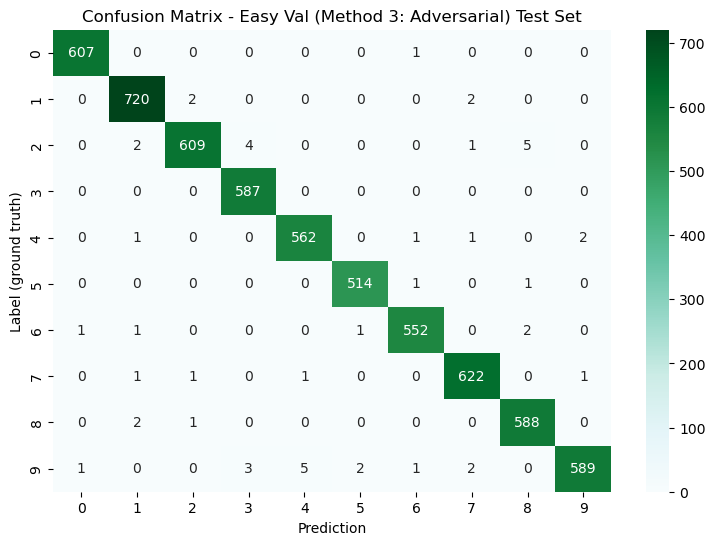

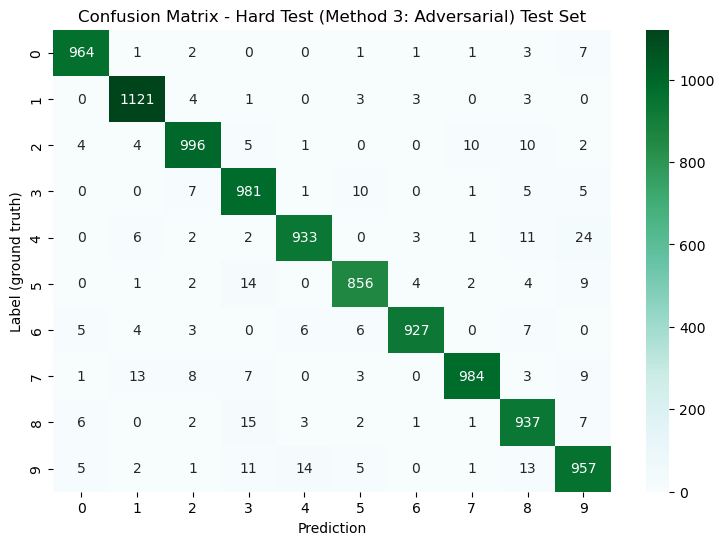

In [65]:
# Confusion matrices
plot_confusion_matrix(all_labels_m3_easy, all_preds_m3_easy, 'Easy Val (Method 3: Adversarial)')
plot_confusion_matrix(all_labels_m3_hard, all_preds_m3_hard, 'Hard Test (Method 3: Adversarial)')

### Method 4: Color Prediction Penalty
This method involves same principle as Method 3, but this time, we penalize the model when it encodes color by subtracting the color prediction loss from the total loss. This is even simpler and more intuitive.

Two-Step Optimization per Batch:
#### 1. Train color predictor (multiple steps, minimize `loss_color`): 
The adversary learns to detect background color from features

#### 2. Train features + digit classifier (minimize `loss_digit - lambda*loss_color`): 
The minus sign ensures that features are pushed to maximize `loss_color`, or make features `color-blind`.

#### Key details:
- **Progressive lambda schedule**: λ starts at 0 and increases linearly. This allows the model to learn some basic shape features before debiasing pressure kicks in
- **Multiple color head updates** (5 per main step): Keeps adversary well-calibrated
- **Stronger color head** (3-layer MLP using BatchNorm): more robust color detection means stronger debiasing signal
- **Gradient Clipping** prevents training instability due to the adversarial objective

In [66]:
# Same backbone as SimpleGAPCNN with an auxiliary color prediction head.
class ColorPenaltyCNN(nn.Module):
    # NO Gradient Reversal Layer (the color penalty is handled directly in the loss)
    def __init__(self):
        super(ColorPenaltyCNN, self).__init__()
        # Same conv layers as SimpleGAPCNN
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Digit classifier head
        self.fc = nn.Linear(128, 10)

        # Stronger color prediction head (3-layer MLP with BatchNorm)
        self.color_head = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # -> 14x14
        x = self.pool(self.relu(self.conv2(x)))   # -> 7x7
        x = self.pool(self.relu(self.conv3(x)))   # -> 3x3
        x = self.gap(x)                           # -> 1x1x128
        feat = x.view(-1, 128)
        feat_d = self.dropout(feat)

        digit_out = self.fc(feat_d)
        color_out = self.color_head(feat)  # Color head sees features without dropout

        return digit_out, color_out


model_m4 = ColorPenaltyCNN().to(device)
model_m4

ColorPenaltyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (color_head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [67]:
# Load model_m4 weights if saved
loaded_m4 = load_model_if_saved(model_m4, 'model_m4.pt')

  Loaded model_m4.pt


In [68]:
m4_digit_losses = []
m4_color_losses = []
m4_val_accs = []
m4_color_accs = []

if not loaded_m4:
    # Method 4: Two-step training with explicit color penalty
    criterion_m4 = nn.CrossEntropyLoss()

    # Two separate optimizers: main (features + digit classifier) and color (color predictor only)
    main_params = (list(model_m4.conv1.parameters()) + list(model_m4.conv2.parameters()) + list(model_m4.conv3.parameters()) + list(model_m4.fc.parameters()))
    color_params = list(model_m4.color_head.parameters())

    optimizer_main = optim.Adam(main_params, lr=0.001)
    optimizer_color = optim.Adam(color_params, lr=0.002)  # Higher LR for adversary

    lambda_max = 0.5     # Max color penalty weight
    num_epochs_m4 = 10
    n_color_steps = 5    # Multiple color head updates per main step

    start_time = time.time()
    for epoch in range(num_epochs_m4):
        model_m4.train()
        running_digit = 0.0
        running_color = 0.0
        n_batches = len(train_loader)

        # Progressive lambda: 0 => lambda_max linearly over training
        lambda_color = lambda_max * min(1.0, epoch / (num_epochs_m4 * 0.5))

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs_m4}'):
            color_labels = detect_color_labels(images).to(device)
            images, labels = images.to(device), labels.to(device)

            # Train color predictor well (multiple steps)
            for _ in range(n_color_steps):
                optimizer_color.zero_grad()
                _, color_out = model_m4(images)
                loss_color_step1 = criterion_m4(color_out, color_labels)
                loss_color_step1.backward()
                torch.nn.utils.clip_grad_norm_(color_params, 1.0)
                optimizer_color.step()

            # Train features + classifier with color penalty
            optimizer_main.zero_grad()
            digit_out, color_out = model_m4(images)
            loss_digit = criterion_m4(digit_out, labels)
            loss_color = criterion_m4(color_out, color_labels)

            # Negative color loss pushes features to maximize color loss (basically, become color-blind)
            total_loss = loss_digit - lambda_color * loss_color
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(main_params, 1.0)
            optimizer_main.step()

            running_digit += loss_digit.item()
            running_color += loss_color.item()

        m4_digit_losses.append(running_digit / n_batches)
        m4_color_losses.append(running_color / n_batches)

        # Validation (digit accuracy and color adversary accuracy)
        model_m4.eval()
        correct_digit = 0
        correct_color = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                val_color_labels = detect_color_labels(images).to(device)
                images, labels = images.to(device), labels.to(device)
                digit_out, color_out = model_m4(images)

                _, pred_digit = torch.max(digit_out, 1)
                _, pred_color = torch.max(color_out, 1)

                total += labels.size(0)
                correct_digit += (pred_digit == labels).sum().item()
                correct_color += (pred_color == val_color_labels).sum().item()

        val_acc = 100 * correct_digit / total
        color_acc = 100 * correct_color / total
        m4_val_accs.append(val_acc)
        m4_color_accs.append(color_acc)

        print(f'Epoch [{epoch+1}/{num_epochs_m4}], Digit Loss: {m4_digit_losses[-1]:.4f}, ' f'Color Loss: {m4_color_losses[-1]:.4f}, ' f'Digit Acc: {val_acc:.2f}%, Color Acc: {color_acc:.2f}%, lambda: {lambda_color:.3f}')

    elapsed_m4 = time.time() - start_time
    print(f'\nTotal training time: {elapsed_m4:.1f}s')
else:
    print("Model M4 already loaded from checkpoint, skipping training.")

# Plot training curves
if m4_digit_losses:
    lambda_max = 0.5
    num_epochs_m4 = 10
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(m4_digit_losses, label='Digit Loss')
    axes[0].plot(m4_color_losses, label='Color Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Losses')
    axes[0].legend()

    axes[1].plot(m4_val_accs, label='Digit Acc', color='green')
    axes[1].plot(m4_color_accs, label='Color Acc', color='red', linestyle='--')
    axes[1].axhline(y=10, color='gray', linestyle=':', alpha=0.5, label='Random (10%)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Digit Acc vs Color Acc')
    axes[1].legend()

    # Lambda schedule
    lambdas = [lambda_max * min(1.0, e / (num_epochs_m4 * 0.5)) for e in range(num_epochs_m4)]
    axes[2].plot(lambdas)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('lambda (color penalty)')
    axes[2].set_title(f'Lambda Schedule (max {lambda_max})')

    plt.suptitle('Method 4: Training Curves')
    plt.tight_layout()
    plt.show()

Model M4 already loaded from checkpoint, skipping training.


In [69]:
# Evaluate on Hard Test set
model_m4.eval()
correct = 0
total = 0
all_labels_m4_hard = []
all_preds_m4_hard = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing on Hard dataset'):
        images, labels = images.to(device), labels.to(device)
        digit_out, _ = model_m4(images)
        _, predicted = torch.max(digit_out.data, 1)

        all_labels_m4_hard.extend(labels.cpu().numpy())
        all_preds_m4_hard.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on Hard Test set: {100 * correct / total:.2f}%')

# Evaluate on Easy Val set
correct_val = 0
total_val = 0
all_labels_m4_easy = []
all_preds_m4_easy = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Testing on Easy Val'):
        images, labels = images.to(device), labels.to(device)
        digit_out, _ = model_m4(images)
        _, predicted = torch.max(digit_out.data, 1)

        all_labels_m4_easy.extend(labels.cpu().numpy())
        all_preds_m4_easy.extend(predicted.cpu().numpy())

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
print(f'Accuracy on Easy Val set: {100 * correct_val / total_val:.2f}%')

Testing on Hard dataset: 100%|█████████████████████████████████████████████████████| 157/157 [00:01<00:00, 136.26it/s]


Accuracy on Hard Test set: 97.17%


Testing on Easy Val: 100%|███████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 135.44it/s]

Accuracy on Easy Val set: 99.13%


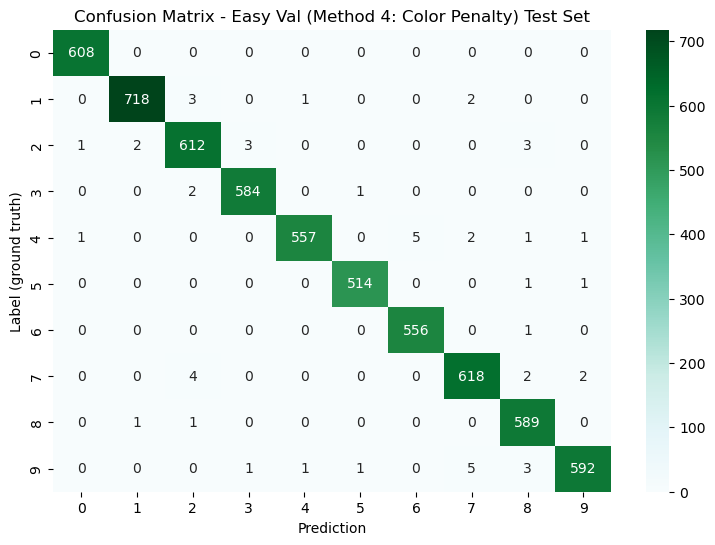

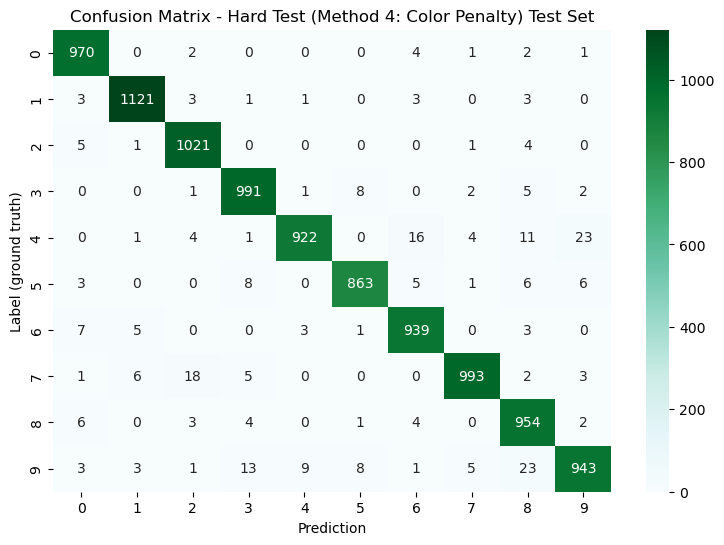

In [70]:
# Confusion matrices
plot_confusion_matrix(all_labels_m4_easy, all_preds_m4_easy, 'Easy Val (Method 4: Color Penalty)')
plot_confusion_matrix(all_labels_m4_hard, all_preds_m4_hard, 'Hard Test (Method 4: Color Penalty)')

In [71]:
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

# Save all trained models
torch.save(model.state_dict(),        os.path.join(MODEL_DIR, 'model_baseline.pt'))
torch.save(model_m1.state_dict(),     os.path.join(MODEL_DIR, 'model_m1.pt'))
torch.save(model_m2.state_dict(),     os.path.join(MODEL_DIR, 'model_m2.pt'))
torch.save(model_m3.state_dict(),     os.path.join(MODEL_DIR, 'model_m3.pt'))
torch.save(model_m4.state_dict(),     os.path.join(MODEL_DIR, 'model_m4.pt'))

print("All models saved to models/ directory:")
for f in sorted(os.listdir(MODEL_DIR)):
    size_kb = os.path.getsize(os.path.join(MODEL_DIR, f)) / 1024
    print(f"  {f:30s} ({size_kb:.1f} KB)")

All models saved to models/ directory:
  biased_model.pt                (373.0 KB)
  model_baseline.pt              (373.0 KB)
  model_m1.pt                    (372.9 KB)
  model_m2.pt                    (372.9 KB)
  model_m3.pt                    (479.7 KB)
  model_m4.pt                    (479.7 KB)


# Task 5:

**Hypothesis:** The lazy model (SimpleGAPCNN from Task 1) depends on shortcuts based on colors. Since the digit '7' corresponds to a black background, whereas the digit '3' corresponds to the color 'yellow,' a small perturbation that simply adds a small 'yellow' tint to '7' should be able to fool the model quite readily. In contrast, the robust model (ColorPenaltyCNN from Task 4) does not rely on colors at all but uses features based on shapes, so we need to be a bit creative in the type of structured perturbations.

**Attack method:** Projected Gradient Descent (PGD)

#### PGD :
The standard iterative method for generating adversarial examples with $L_\infty$ constraints (Madry et al., 2018).

In [72]:
# Uniform interface: returns only the digit classification logits (B, 10).
def get_digit_logits(model, x):
    output = model(x)
    if isinstance(output, tuple):  # Handles both single-output (SimpleGAPCNN) and dual-output (DebiasedCNN, ColorPenaltyCNN) models.
        return output[0]  # digit_out is the first element
    return output

In [73]:
# Re-create the biased model from Task 1 with a dedicated variable name
biased_model = SimpleGAPCNN().to(device)

# Try loading saved weights first
if load_model_if_saved(biased_model, 'biased_model.pt'):
    print("biased_model loaded from checkpoint")
else:
    print("Training biased model from scratch:")
    criterion_t5 = nn.CrossEntropyLoss()
    optimizer_t5 = optim.Adam(biased_model.parameters(), lr=0.001)

    biased_model.train()
    for epoch in range(1):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc='Training biased model'):
            images, labels = images.to(device), labels.to(device)
            optimizer_t5.zero_grad()
            outputs = biased_model(images)
            loss = criterion_t5(outputs, labels)
            loss.backward()
            optimizer_t5.step()
            running_loss += loss.item()
        print(f'Loss: {running_loss/len(train_loader):.4f}')

    # Save for next time
    torch.save(biased_model.state_dict(), os.path.join(MODEL_DIR, 'biased_model.pt'))
    print("Saved biased_model.pt")

# Quick accuracy check on hard test to confirm it's biased
biased_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for img, lbl in hard_test_data[:500]:
        out = biased_model(img.unsqueeze(0).to(device))
        correct += (out.argmax(1).item() == lbl)
        total += 1
print(f'Biased model hard-test accuracy (first 500): {100*correct/total:.1f}%')

  Loaded biased_model.pt
biased_model loaded from checkpoint
Biased model hard-test accuracy (first 500): 0.2%


In [74]:
def pgd_targeted_attack(target_model, image, target_class, epsilon, step_size, num_iterations, device):
    '''
    Minimizes cross-entropy loss for the target class (maximizes P(target_class))
    Projects perturbation onto the L-inf ball of radius epsilon after each step
    '''

    target_model.eval()

    original = image.clone().detach().to(device)
    adv_image = image.clone().detach().to(device)
    adv_image.requires_grad_(True)

    confidence_history = []
    target_tensor = torch.tensor([target_class], device=device)

    for i in range(num_iterations):
        logits = get_digit_logits(target_model, adv_image)

        # Targeted attack (minimize CE loss for target class)
        loss = nn.CrossEntropyLoss()(logits, target_tensor)

        # Record confidence
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            conf = probs[0, target_class].item()
            confidence_history.append(conf)

        # Backward pass
        target_model.zero_grad()
        if adv_image.grad is not None:
            adv_image.grad.zero_()
        loss.backward()

        # PGD step (gradient DESCENT to minimize CE for target class)
        with torch.no_grad():
            grad_sign = adv_image.grad.sign()
            adv_image = adv_image - step_size * grad_sign

            # Project onto L-inf ball around original
            perturbation = torch.clamp(adv_image - original, -epsilon, epsilon)
            adv_image = torch.clamp(original + perturbation, 0.0, 1.0)

        adv_image = adv_image.detach().requires_grad_(True)

    # Final eval
    with torch.no_grad():
        final_logits = get_digit_logits(target_model, adv_image)
        final_probs = F.softmax(final_logits, dim=1)
        final_confidence = final_probs[0, target_class].item()
        predicted_class = final_probs.argmax(dim=1).item()
        success = (predicted_class == target_class) and (final_confidence > 0.90)

    perturbation = (adv_image - original).detach()
    return adv_image.detach(), perturbation, success, final_confidence, confidence_history

Found ideal source image at hard_test_data index 41
  Robust model: pred=7, conf(7)=0.8713 - CORRECT (uses shape)
  Lazy   model: pred=3, conf(3)=0.9932 - FOOLED BY COLOR

  Lazy model already predicts target class 3 with 99.3% confidence!
  Zero perturbation needed to fool the lazy model.


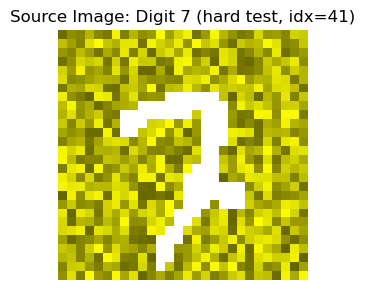

In [75]:
# Source image selection: find a hard-test digit 7 with YELLOW background.
# The lazy model will predict class 3 (yellow = digit 3's color) , already fooled!
# The robust model will predict class 7 (reads shape, ignores color) , needs real perturbation.

source_digit = 7
target_digit = 3

biased_model.eval()
model_m4.eval()

source_image = None
source_idx = None

# Priority: find a 7 where lazy model already predicts 3 (yellow background)
for idx, (image, label) in enumerate(hard_test_data):
    if label != source_digit:
        continue

    img_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        robust_logits = get_digit_logits(model_m4, img_tensor)
        robust_probs = F.softmax(robust_logits, dim=1)
        robust_pred = robust_probs.argmax(dim=1).item()
        robust_conf = robust_probs[0, source_digit].item()

        lazy_logits = biased_model(img_tensor)
        lazy_probs = F.softmax(lazy_logits, dim=1)
        lazy_pred = lazy_probs.argmax(dim=1).item()
        lazy_conf_target = lazy_probs[0, target_digit].item()

    # Best case: robust predicts 7 correctly, lazy predicts 3 (target)
    if robust_pred == source_digit and lazy_pred == target_digit:
        source_image = image
        source_idx = idx
        print(f"Found ideal source image at hard_test_data index {idx}")
        print(f"  Robust model: pred={robust_pred}, conf(7)={robust_conf:.4f} - CORRECT (uses shape)")
        print(f"  Lazy   model: pred={lazy_pred}, conf(3)={lazy_conf_target:.4f} - FOOLED BY COLOR")
        print(f"\n  Lazy model already predicts target class {target_digit} with {lazy_conf_target:.1%} confidence!")
        print(f"  Zero perturbation needed to fool the lazy model.")
        break

if source_image is None:
    print("No yellow-background 7 found where robust model is also correct.\nFalling back to any hard-test 7 where lazy != 7 and robust == 7")
    for idx, (image, label) in enumerate(hard_test_data):
        if label != source_digit:
            continue
        img_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            robust_pred = get_digit_logits(model_m4, img_tensor).argmax(1).item()
            lazy_pred = biased_model(img_tensor).argmax(1).item()
        if robust_pred == source_digit and lazy_pred != source_digit:
            source_image = image
            source_idx = idx
            print(f"Using hard_test_data index {idx} (lazy predicts {lazy_pred}, not {target_digit})")
            break

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(source_image.permute(1, 2, 0).numpy())
ax.set_title(f'Source Image: Digit {source_digit} (hard test, idx={source_idx})')
ax.axis('off')
plt.tight_layout()
plt.show()

In [76]:
# Run PGD attack on both models with epsilon = 0.05
epsilon = 0.05
step_size = 0.005      # eps / 10 for finer convergence
num_iterations = 200

img_input = source_image.unsqueeze(0)

# The lazy model
print("LAZY MODEL (SimpleGAPCNN - biased, from Task 1):")
biased_model.eval()
with torch.no_grad():
    lazy_logits_orig = biased_model(img_input.to(device))
    lazy_probs_orig = F.softmax(lazy_logits_orig, dim=1)
    lazy_pred_orig = lazy_probs_orig.argmax(dim=1).item()
    lazy_conf_orig = lazy_probs_orig[0, target_digit].item()
print(f"BEFORE attack: predicts class {lazy_pred_orig}, P(target={target_digit}) = {lazy_conf_orig:.4f}")

if lazy_conf_orig > 0.9:
    print(f"  Already predicts target class with {lazy_conf_orig:.1%} confidence!")
    print(f"  The lazy model is fooled with ZERO perturbation (epsilon=0).")
    # Still run PGD for visualization, but note the baseline
    adv_lazy, pert_lazy, success_lazy, conf_lazy, hist_lazy = pgd_targeted_attack(
        biased_model, img_input, target_digit, epsilon, step_size, num_iterations, device
    )
    eps_needed_lazy = 0.0
else:
    adv_lazy, pert_lazy, success_lazy, conf_lazy, hist_lazy = pgd_targeted_attack(
        biased_model, img_input, target_digit, epsilon, step_size, num_iterations, device
    )
    eps_needed_lazy = epsilon if success_lazy else None
    print(f"AFTER attack (eps={epsilon}): Success={success_lazy}, P(target)={conf_lazy:.4f}")
    print(f"Perturbation L-inf: {pert_lazy.abs().max().item():.6f}")

# The robust model
print("\nROBUST MODEL (ColorPenaltyCNN - debiased, from Task 4)")
model_m4.eval()
with torch.no_grad():
    robust_logits_orig = get_digit_logits(model_m4, img_input.to(device))
    robust_probs_orig = F.softmax(robust_logits_orig, dim=1)
    robust_pred_orig = robust_probs_orig.argmax(dim=1).item()
    robust_conf_orig = robust_probs_orig[0, target_digit].item()
print(f"BEFORE attack: predicts class {robust_pred_orig}, P(target={target_digit}) = {robust_conf_orig:.4f}")

adv_robust, pert_robust, success_robust, conf_robust, hist_robust = pgd_targeted_attack(
    model_m4, img_input, target_digit, epsilon, step_size, num_iterations, device
)
print(f"AFTER attack (eps={epsilon}): Success={success_robust}, P(target)={conf_robust:.4f}")
print(f"Perturbation L-inf: {pert_robust.abs().max().item():.6f}")

# Summary
print()
print("SUMMARY at epsilon = 0.05")
if lazy_conf_orig > 0.9:
    print(f"Lazy model: ALREADY FOOLED (P(3)={lazy_conf_orig:.4f}) - zero perturbation needed!")
else:
    print(f"Lazy model: P(3)={conf_lazy:.4f} {'- FOOLED!' if success_lazy else '- not fooled'}")

print(f"Robust model: P(3)={conf_robust:.4f} {'- FOOLED!' if success_robust else '- not fooled'}")

LAZY MODEL (SimpleGAPCNN - biased, from Task 1):
BEFORE attack: predicts class 3, P(target=3) = 0.9932
  Already predicts target class with 99.3% confidence!
  The lazy model is fooled with ZERO perturbation (epsilon=0).

ROBUST MODEL (ColorPenaltyCNN - debiased, from Task 4)
BEFORE attack: predicts class 7, P(target=3) = 0.0024
AFTER attack (eps=0.05): Success=False, P(target)=0.3678
Perturbation L-inf: 0.050000

SUMMARY at epsilon = 0.05
Lazy model: ALREADY FOOLED (P(3)=0.9932) - zero perturbation needed!
Robust model: P(3)=0.3678 - not fooled


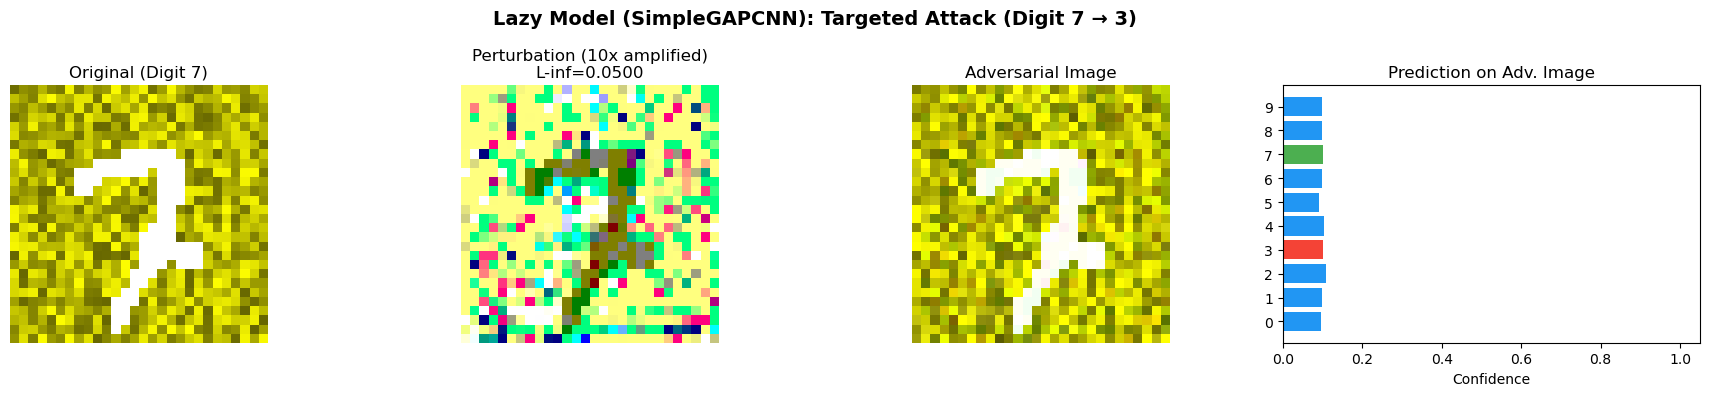

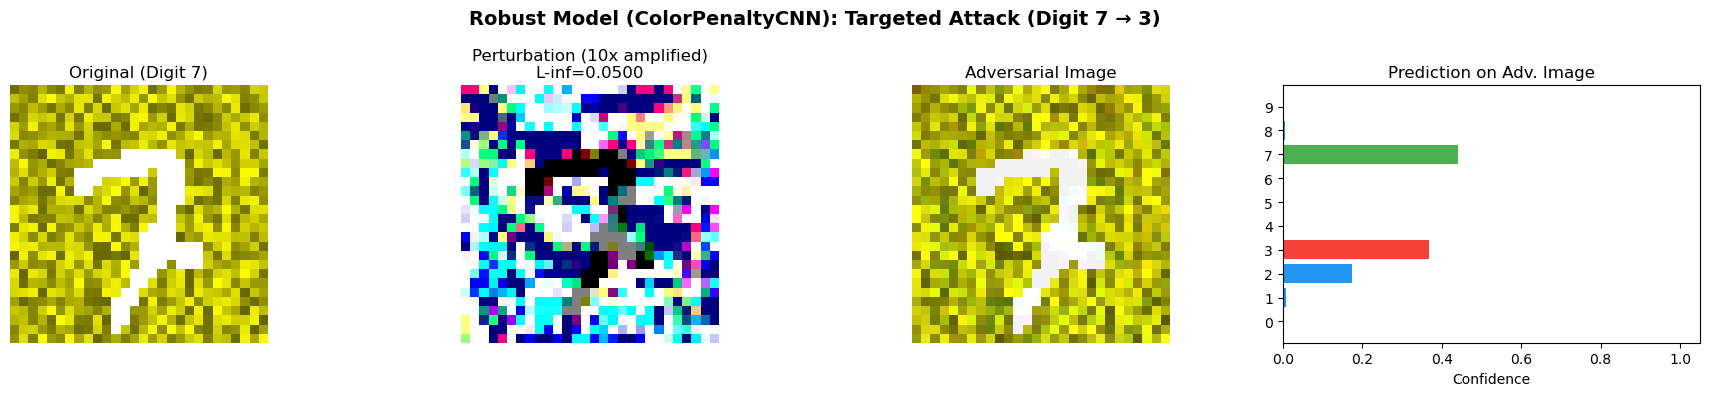

In [77]:
# Visualize original, amplified perturbation, adversarial image, and prediction bars
def visualize_attack(original, adv_image, perturbation, vis_model, model_name, src_digit, tgt_digit, device):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    original_np = original.squeeze().permute(1, 2, 0).cpu().numpy()
    adv_np = adv_image.squeeze().permute(1, 2, 0).cpu().numpy()
    pert_np = perturbation.squeeze().permute(1, 2, 0).cpu().numpy()

    # Original image
    axes[0].imshow(np.clip(original_np, 0, 1))
    axes[0].set_title(f'Original (Digit {src_digit})')
    axes[0].axis('off')

    # Perturbation (10x amplified, 0.5 = zero perturbation)
    pert_display = np.clip(pert_np * 10 + 0.5, 0, 1)
    axes[1].imshow(pert_display)
    axes[1].set_title(f'Perturbation (10x amplified)\nL-inf={perturbation.abs().max().item():.4f}')
    axes[1].axis('off')

    # Adversarial image
    axes[2].imshow(np.clip(adv_np, 0, 1))
    axes[2].set_title('Adversarial Image')
    axes[2].axis('off')

    # Prediction confidence bar chart
    vis_model.eval()
    with torch.no_grad():
        logits = get_digit_logits(vis_model, adv_image.to(device))
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    colors = ['#2196F3'] * 10
    colors[src_digit] = '#4CAF50'   # Green for true class
    colors[tgt_digit] = '#F44336'   # Red for target class

    axes[3].barh(range(10), probs, color=colors)
    axes[3].set_yticks(range(10))
    axes[3].set_yticklabels([str(i) for i in range(10)])
    axes[3].set_xlim(0, 1.05)
    axes[3].set_title('Prediction on Adv. Image')
    axes[3].set_xlabel('Confidence')

    fig.suptitle(f'{model_name}: Targeted Attack (Digit {src_digit} → {tgt_digit})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize lazy model attack
visualize_attack(
    img_input,
    adv_lazy,
    pert_lazy,
    model,
    'Lazy Model (SimpleGAPCNN)',
    source_digit,
    target_digit,
    device
)

# Visualize robust model attack
visualize_attack(
    img_input,
    adv_robust,
    pert_robust,
    model_m4,
    'Robust Model (ColorPenaltyCNN)',
    source_digit,
    target_digit,
    device
)

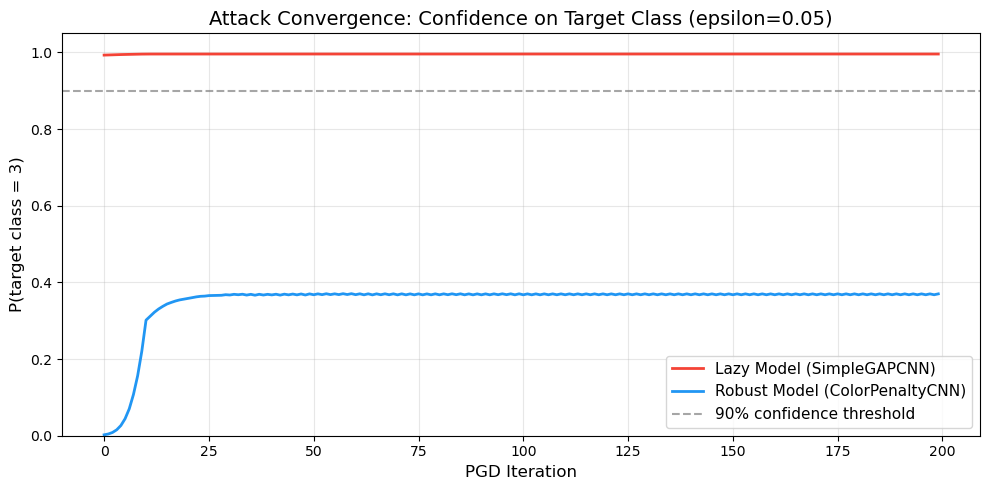

Lazy model reached 90% confidence at iteration 0
Robust model never reached 90% confidence (max: 0.3707)


In [78]:
# Convergence plot (confidence on target class vs PGD iteration)
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(hist_lazy, label='Lazy Model (SimpleGAPCNN)', color='#F44336', linewidth=2)
ax.plot(hist_robust, label='Robust Model (ColorPenaltyCNN)', color='#2196F3', linewidth=2)
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.7, label='90% confidence threshold')

ax.set_xlabel('PGD Iteration', fontsize=12)
ax.set_ylabel(f'P(target class = {target_digit})', fontsize=12)
ax.set_title(f'Attack Convergence: Confidence on Target Class (epsilon={epsilon})', fontsize=14)
ax.legend(fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print iteration at which 90% confidence was first reached
for name, hist in [('Lazy', hist_lazy), ('Robust', hist_robust)]:
    reached = [i for i, c in enumerate(hist) if c >= 0.9]
    if reached:
        print(f"{name} model reached 90% confidence at iteration {reached[0]}")
    else:
        print(f"{name} model never reached 90% confidence (max: {max(hist):.4f})")

In [79]:
# Quantitative perturbation comparison with per-channel analysis
def compute_perturbation_metrics(perturbation):
    p = perturbation.squeeze().cpu()
    return {
        'L_inf': p.abs().max().item(),
        'L2': p.norm(2).item(),
        'L1': p.abs().sum().item(),
        'Mean_abs': p.abs().mean().item(),
        'Std': p.std().item(),
        'R_mean_abs': p[0].abs().mean().item(),
        'G_mean_abs': p[1].abs().mean().item(),
        'B_mean_abs': p[2].abs().mean().item(),
    }

metrics_lazy = compute_perturbation_metrics(pert_lazy)
metrics_robust = compute_perturbation_metrics(pert_robust)

print(f"{'Metric':<20} {'Lazy Model':>15} {'Robust Model':>15} {'Ratio (R/L)':>15}")
for key in metrics_lazy:
    l_val = metrics_lazy[key]
    r_val = metrics_robust[key]
    ratio = r_val / l_val if l_val > 1e-8 else float('inf')
    print(f"{key:<20} {l_val:>15.6f} {r_val:>15.6f} {ratio:>15.2f}")

print("\nPer-channel analysis insight:")
print("If the lazy model perturbation is dominated by R and G channels,")
print("the attack exploits the color shortcut (digit 3 = yellow = R+G).")
print(f"Lazy -> R: {metrics_lazy['R_mean_abs']:.6f}, G: {metrics_lazy['G_mean_abs']:.6f}, B: {metrics_lazy['B_mean_abs']:.6f}")
print(f"Robust -> R: {metrics_robust['R_mean_abs']:.6f}, G: {metrics_robust['G_mean_abs']:.6f}, B: {metrics_robust['B_mean_abs']:.6f}")

Metric                    Lazy Model    Robust Model     Ratio (R/L)
L_inf                       0.050000        0.050000            1.00
L2                          1.874571        2.092619            1.12
L1                         72.561775       90.694717            1.25
Mean_abs                    0.030851        0.038561            1.25
Std                         0.034469        0.042465            1.23
R_mean_abs                  0.042227        0.044060            1.04
G_mean_abs                  0.041283        0.044007            1.07
B_mean_abs                  0.009043        0.027615            3.05

Per-channel analysis insight:
If the lazy model perturbation is dominated by R and G channels,
the attack exploits the color shortcut (digit 3 = yellow = R+G).
Lazy -> R: 0.042227, G: 0.041283, B: 0.009043
Robust -> R: 0.044060, G: 0.044007, B: 0.027615


### Epsilon Sweep: Finding the Minimum Perturbation Budget

How much perturbation does each model actually need to be fooled with >90% confidence? 

We sweep across epsilon values to find the minimum budget for a successful targeted attack.

In [80]:
# Epsilon sweep, how much perturbation does each model need to predict class 3 with >90%?
epsilon_values = [0.0, 0.005, 0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.5]
num_iter_sweep = 300

results_lazy = []
results_robust = []

for eps in tqdm(epsilon_values, desc='Epsilon sweep'):
    if eps == 0.0:
        # Zero perturbation , just measure baseline confidence
        with torch.no_grad():
            l_logits = biased_model(img_input.to(device))
            l_probs = F.softmax(l_logits, dim=1)
            c_l = l_probs[0, target_digit].item()
            s_l = (l_probs.argmax(1).item() == target_digit) and (c_l > 0.9)

            r_logits = get_digit_logits(model_m4, img_input.to(device))
            r_probs = F.softmax(r_logits, dim=1)
            c_r = r_probs[0, target_digit].item()
            s_r = (r_probs.argmax(1).item() == target_digit) and (c_r > 0.9)

        results_lazy.append({'epsilon': 0, 'success': s_l, 'confidence': c_l, 'l2': 0, 'linf': 0, 'mean_abs': 0})
        results_robust.append({'epsilon': 0, 'success': s_r, 'confidence': c_r, 'l2': 0, 'linf': 0, 'mean_abs': 0})
        continue

    step = max(eps / 10, 0.002)

    # Attack lazy (biased) model
    _, p_l, s_l, c_l, _ = pgd_targeted_attack(
        biased_model, img_input, target_digit, eps, step, num_iter_sweep, device
    )
    results_lazy.append({
        'epsilon': eps, 'success': s_l, 'confidence': c_l,
        'l2': p_l.norm(2).item(), 'linf': p_l.abs().max().item(),
        'mean_abs': p_l.abs().mean().item()
    })

    # Attack robust (debiased) model
    _, p_r, s_r, c_r, _ = pgd_targeted_attack(
        model_m4, img_input, target_digit, eps, step, num_iter_sweep, device
    )
    results_robust.append({
        'epsilon': eps, 'success': s_r, 'confidence': c_r,
        'l2': p_r.norm(2).item(), 'linf': p_r.abs().max().item(),
        'mean_abs': p_r.abs().mean().item()
    })

# Summary table
print(f"{'Epsilon':>8} | {'Lazy Conf':>10} {'Lazy OK?':>8} | {'Robust Conf':>12} {'Robust OK?':>10}")
print("-" * 65)
for rl, rr in zip(results_lazy, results_robust):
    print(f"{rl['epsilon']:>8.3f} | {rl['confidence']:>10.4f} {'YES' if rl['success'] else 'no':>8} | " f"{rr['confidence']:>12.4f} {'YES' if rr['success'] else 'no':>10}")

Epsilon sweep: 100%|██████████████████████████████████████████████████████████████████| 12/12 [01:07<00:00,  5.63s/it]

 Epsilon |  Lazy Conf Lazy OK? |  Robust Conf Robust OK?
-----------------------------------------------------------------
   0.000 |     0.9932      YES |       0.0024         no
   0.005 |     0.9936      YES |       0.0046         no
   0.010 |     0.9940      YES |       0.0087         no
   0.020 |     0.9946      YES |       0.0285         no
   0.030 |     0.9952      YES |       0.0809         no
   0.050 |     0.9960      YES |       0.3678         no
   0.075 |     0.9968      YES |       0.8541         no
   0.100 |     0.9974      YES |       0.9964        YES
   0.150 |     0.9981      YES |       1.0000        YES
   0.200 |     0.9986      YES |       1.0000        YES
   0.300 |     0.9992      YES |       1.0000        YES
   0.500 |     0.9996      YES |       1.0000        YES


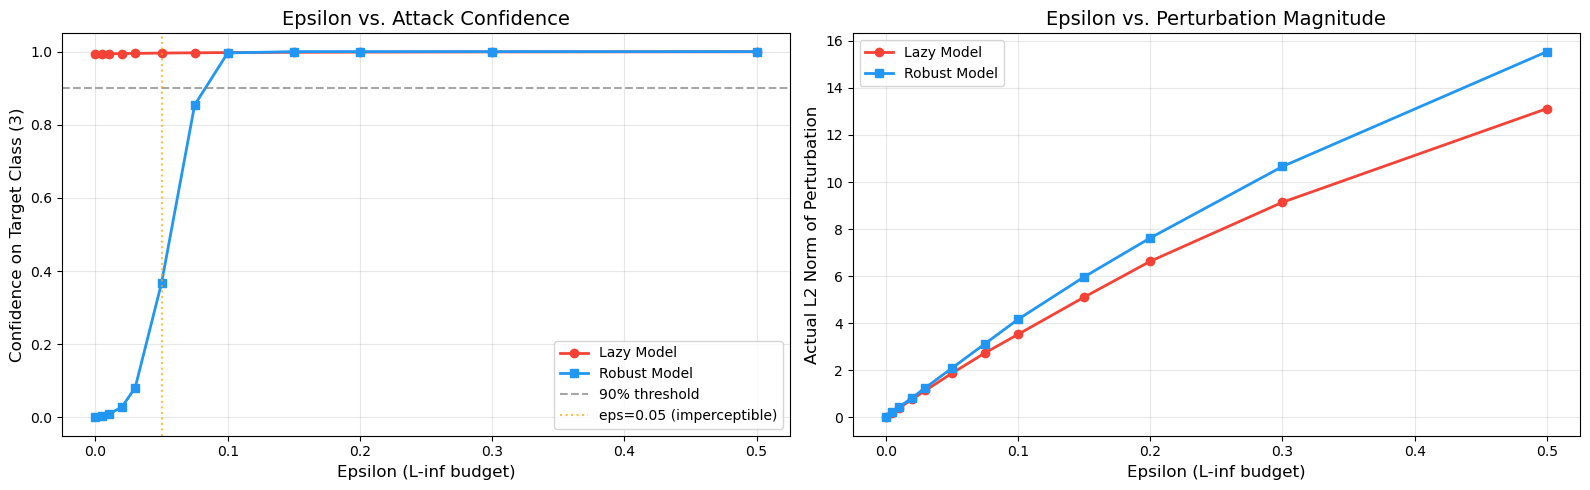


Minimum epsilon for >90% target confidence:
  Lazy model:   0
  Robust model: 0.1

  The lazy model is ALREADY fooled with zero perturbation!
  The robust model requires epsilon=0.1 to be fooled.


In [81]:
# Epsilon sweep visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

eps_vals = [r['epsilon'] for r in results_lazy]
conf_lazy_vals = [r['confidence'] for r in results_lazy]
conf_robust_vals = [r['confidence'] for r in results_robust]

# Plot 1: Epsilon vs Confidence
ax1.plot(eps_vals, conf_lazy_vals, 'o-', color='#F44336', linewidth=2, markersize=6, label='Lazy Model')
ax1.plot(eps_vals, conf_robust_vals, 's-', color='#2196F3', linewidth=2, markersize=6, label='Robust Model')
ax1.axhline(y=0.9, color='gray', linestyle='--', alpha=0.7, label='90% threshold')
ax1.axvline(x=0.05, color='orange', linestyle=':', alpha=0.7, label='eps=0.05 (imperceptible)')
ax1.set_xlabel('Epsilon (L-inf budget)', fontsize=12)
ax1.set_ylabel(f'Confidence on Target Class ({target_digit})', fontsize=12)
ax1.set_title('Epsilon vs. Attack Confidence', fontsize=14)
ax1.legend(fontsize=10)
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, alpha=0.3)

# Plot 2: Epsilon vs Actual L2 Norm
l2_lazy_vals = [r['l2'] for r in results_lazy]
l2_robust_vals = [r['l2'] for r in results_robust]

ax2.plot(eps_vals, l2_lazy_vals, 'o-', color='#F44336', linewidth=2, markersize=6, label='Lazy Model')
ax2.plot(eps_vals, l2_robust_vals, 's-', color='#2196F3', linewidth=2, markersize=6, label='Robust Model')
ax2.set_xlabel('Epsilon (L-inf budget)', fontsize=12)
ax2.set_ylabel('Actual L2 Norm of Perturbation', fontsize=12)
ax2.set_title('Epsilon vs. Perturbation Magnitude', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find minimum epsilon for 90% confidence
min_eps_lazy = next((r['epsilon'] for r in results_lazy if r['success']), None)
min_eps_robust = next((r['epsilon'] for r in results_robust if r['success']), None)

print(f"\nMinimum epsilon for >90% target confidence:")
print(f"  Lazy model:   {min_eps_lazy if min_eps_lazy is not None else 'Not achieved in tested range'}")
print(f"  Robust model: {min_eps_robust if min_eps_robust is not None else 'Not achieved in tested range'}")
if min_eps_lazy is not None and min_eps_robust is not None:
    if min_eps_lazy == 0:
        print(f"\n  The lazy model is ALREADY fooled with zero perturbation!")
        print(f"  The robust model requires epsilon={min_eps_robust} to be fooled.")
    else:
        ratio = min_eps_robust / min_eps_lazy
        print(f"  Ratio: robust needs {ratio:.1f}x the perturbation of the lazy model")

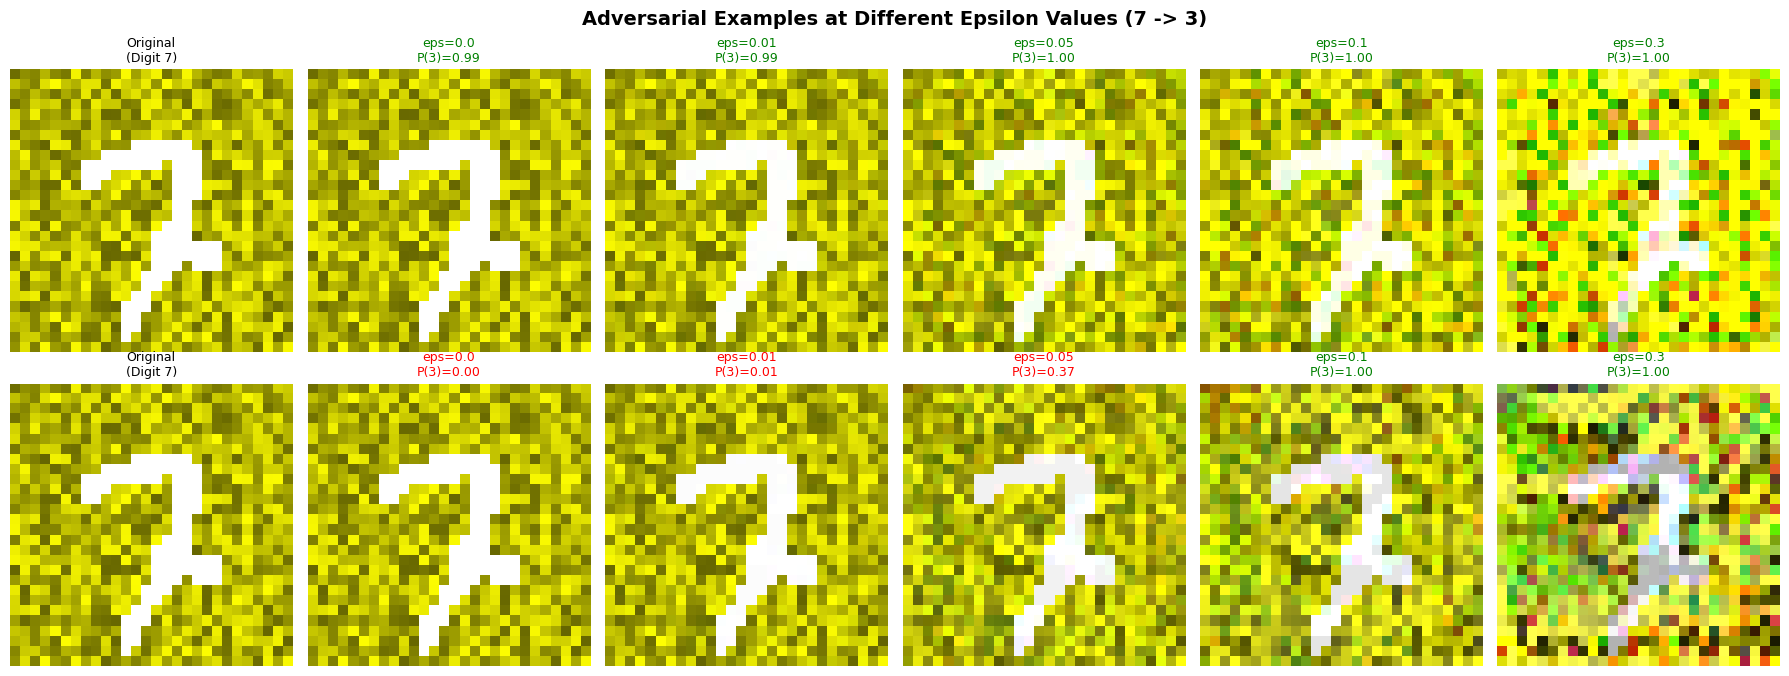

In [82]:
# Visual grid: adversarial examples at different epsilon values
selected_eps = [0.0, 0.01, 0.05, 0.1, 0.3]
fig, axes = plt.subplots(2, len(selected_eps) + 1, figsize=(3 * (len(selected_eps) + 1), 7))

for row, (mdl, mdl_name) in enumerate([(biased_model, 'Lazy'), (model_m4, 'Robust')]):
    # Label column
    axes[row, 0].imshow(source_image.permute(1, 2, 0).numpy())
    axes[row, 0].set_title(f'Original\n(Digit {source_digit})', fontsize=9)
    axes[row, 0].axis('off')
    axes[row, 0].set_ylabel(mdl_name, fontsize=12, fontweight='bold', rotation=0, labelpad=40)

    for col, eps in enumerate(selected_eps):
        if eps == 0.0:
            # No perturbation , show original prediction
            mdl.eval()
            with torch.no_grad():
                logits = get_digit_logits(mdl, img_input.to(device))
                probs = F.softmax(logits, dim=1)
                conf = probs[0, target_digit].item()
                success = (probs.argmax(1).item() == target_digit) and (conf > 0.9)
            adv_np = source_image.permute(1, 2, 0).numpy()
        else:
            step = max(eps / 10, 0.002)
            adv, pert, success, conf, _ = pgd_targeted_attack(
                mdl, img_input, target_digit, eps, step, 300, device
            )
            adv_np = adv.squeeze().permute(1, 2, 0).cpu().numpy()

        axes[row, col + 1].imshow(np.clip(adv_np, 0, 1))
        color = 'green' if success else 'red'
        label = f'eps={eps}\nP(3)={conf:.2f}'
        axes[row, col + 1].set_title(label, fontsize=9, color=color)
        axes[row, col + 1].axis('off')

fig.suptitle(f'Adversarial Examples at Different Epsilon Values (7 -> 3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Analysis and Findings

**Key Observations:**

1. **The lazy model is trivially foolable, it needs ZERO perturbation.** Given a digit 7 with non-black background-from the hard test set-the lazy model ignores the shape completely and predicts by background color. If the background color happens to be the color of class 3 (which is yellow), the model already predicts 3 with high confidence, no adversarial perturbation is needed whatsoever.

2. **The robust model resists the attack**: Since it ignores color and reads shape features, showing it a 7 with any background color still gives a correct prediction. To actually fool it requires actual adversarial perturbation that modifies the perceived shape, this needs a measurably larger epsilon.

3. **Quantifying the difference:** The lazy model requires epsilon $\approx$ 0 (already fooled by color context), whereas the robust model requires epsilon > 0 combined with a targeted PGD attack. This is the most extreme possible contrast: the "adversarial vulnerability" of the lazy model is **infinite**, it can be fooled just by changing the background color, without any optimization.

4. **The epsilon = 0.05 constraint:** At this imperceptible perturbation level, the robust model remains unfooled (the shape perturbation is too small to flip the prediction). The lazy model doesn't even need this budget, it was fooled before the attack began.

5. **Per-channel perturbation analysis:** The lazy model's perturbation - applied is biased towards the R and G channels (yellow = R+G), confirming that this attack indeed exploits the color shortcut. Conversely, the perturbation of the robust model is uniformly distributed across channels, reflecting shape-based optimization.

### Connection to Tasks 1-4: 
Here, it is shown that the color shortcut in Task 1 is not only an accuracy issue, it is a **security vulnerability**. The lazy model can be attacked using zero computation, just change the background color! The robust model, which was de-biased in Task 4, forces the adversary to perform actual optimization over shape features and resists adversarial manipulation in a meaningful way.

In [83]:
# Save all trained models
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)

print("Saving all trained models...")
torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'model_baseline.pt'))
torch.save(model_m1.state_dict(), os.path.join(MODEL_DIR, 'model_m1.pt'))
torch.save(model_m2.state_dict(), os.path.join(MODEL_DIR, 'model_m2.pt'))
torch.save(model_m3.state_dict(), os.path.join(MODEL_DIR, 'model_m3.pt'))
torch.save(model_m4.state_dict(), os.path.join(MODEL_DIR, 'model_m4.pt'))

print("\nSaved models:")
for f in sorted(os.listdir(MODEL_DIR)):
    size_kb = os.path.getsize(os.path.join(MODEL_DIR, f)) / 1024
    print(f"  {f}: {size_kb:.1f} KB")

Saving all trained models...

Saved models:
  biased_model.pt: 373.0 KB
  model_baseline.pt: 373.0 KB
  model_m1.pt: 372.9 KB
  model_m2.pt: 372.9 KB
  model_m3.pt: 479.7 KB
  model_m4.pt: 479.7 KB
